# Import

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #data visualization
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [121]:
from sklearn.metrics import r2_score 

# Load and read data


In [2]:
df = pd.read_csv('../data/online_retail_II.csv')

In [3]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


# Basic EDA
1. Numerical variable: quantity, price
2. Categorical variable: invoice, stockcode, customerId, country
3. Datetime: InvoiceDate
4. Text: Description

In [4]:
# More detailed Overview dataset 
overview_df = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Count': [len(df)]*df.shape[1],
    'Unique Values': df.nunique().values,
    'Null Count': df.isnull().sum().values,
    'Zero Count': (df==0).sum().values,
    'Negative Count': (df.apply(pd.to_numeric, errors='coerce') <0).sum().values,
    'Null(%)': df.isnull().mean().round(4).mul(100).values,
    'Zero (%)': (df==0).mean().round(4).mul(100).values,
    'Negative (%)':(df.apply(pd.to_numeric, errors='coerce') <0).mean().round(4).mul(100).values
    
})

overview_df.style\
    .set_properties(**{'font-weight':'bold'}, subset= ['Column'])\
    .set_properties(**{'text-align':'center'})\
    .format(lambda x: f'{x:,.2f}%', subset=['Null(%)','Zero (%)', 'Negative (%)'])

,Column,Data Type,Count,Unique Values,Null Count,Zero Count,Negative Count,Null(%),Zero (%),Negative (%)
0,Invoice,object,1067371,53628,0,0,0,0.00%,0.00%,0.00%
1,StockCode,object,1067371,5305,0,0,0,0.00%,0.00%,0.00%
2,Description,object,1067371,5698,4382,0,0,0.41%,0.00%,0.00%
3,Quantity,int64,1067371,1057,0,0,22950,0.00%,0.00%,2.15%
4,InvoiceDate,object,1067371,47635,0,0,0,0.00%,0.00%,0.00%
5,Price,float64,1067371,2807,0,6202,5,0.00%,0.58%,0.00%
6,Customer ID,float64,1067371,5942,243007,0,0,22.77%,0.00%,0.00%
7,Country,object,1067371,43,0,0,0,0.00%,0.00%,0.00%


## Numerical variable 

In [5]:
import ipywidgets as widgets

def plot_hist(df, variable):
    plt.figure(figsize = (6,6.5))
    plt.hist(df[variable], bins = 50)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.title("Distribution of {}".format(variable))
    plt.show()
    
def describe_num(df, col_name):
    describe_df = df[[col_name]].describe([x/10 for x in range(10)]+[0.01, 0.05, 0.95, 0.99])
    describe_df[col_name] = describe_df[col_name].apply(lambda x: f"{x:,.2f}")
    table_output = widgets.Output()
    with table_output:
        display(describe_df)
    
    plot_output = widgets.Output()
    with plot_output:
        fig = plot_hist(df, col_name)
        display(fig)

    hbox = widgets.HBox([table_output, plot_output])
    display(hbox)

In [6]:
describe_num(df, 'Quantity')

In [7]:
describe_num(df, 'Price')

In [8]:
describe_num(df[(df.Quantity >= 1) & (df.Quantity <= 30)], 'Quantity')

In [9]:
describe_num(df[(df.Price >= 0) & (df.Price <= 10)], 'Price')

## Categorical Variable


In [10]:
def plot_barh(df_agg, col_name):
    plt.figure(figsize = (6, 5.5))
    plt.barh(df_agg[col_name], df_agg['count'])
    plt.ylabel(col_name)
    plt.xlabel('Number of records')
    plt.title("Top 15 {} by frequency".format(col_name))
    plt.tight_layout()
    plt.show()
    
def describe_categorical(df, col_name):
    cate_des = df[col_name].value_counts().head(15).reset_index()
    total_count = df[col_name].count()
    cate_des["frequency (%)"] = cate_des["count"]/total_count*100
    total_row = pd.DataFrame({
        col_name: ['Total'],
        'count': [total_count],
        'frequency (%)': [100]
    })
    
    cate_df = pd.concat([cate_des, total_row], ignore_index=True)
    cate_df['frequency (%)'] = cate_df['frequency (%)'].apply(lambda x: f"{x:,.2f}%")
    cate_df.style.set_properties(**{'font-weight': 'bold'}, subset=[col_name])
    table_output = widgets.Output()
    with table_output:
        display(cate_df)
    
    plot_output = widgets.Output()
    with plot_output:
        fig = plot_barh(cate_des.sort_values('count', ascending= True), col_name)
        display(fig)

    hbox = widgets.HBox([table_output, plot_output])
    display(hbox)

In [11]:
describe_categorical(df, 'Invoice')

In [12]:
describe_categorical(df, 'StockCode')

In [13]:
describe_categorical(df.astype(str), 'Customer ID')

In [14]:
describe_categorical(df, 'Country')

## Datetime Variable

In [15]:
df["Invoice Date"] = pd.to_datetime(df["InvoiceDate"])

In [16]:
df["year"] = df["Invoice Date"].dt.year
df["month"] = df["Invoice Date"].dt.month
df["day"] = df["Invoice Date"].dt.day
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = pd.Categorical(df['Invoice Date'].dt.strftime('%A'), categories=weekday_order, ordered=True)
df["hour"] = df["Invoice Date"].dt.hour

In [17]:
def plot_bar(df, time_col):
    counts = df[time_col].value_counts().sort_index()
    plt.figure(figsize = (9,3))
    plt.bar(counts.index, counts.values)
    plt.xlabel(time_col)
    plt.xticks(counts.index)
    plt.ylabel("Number of invoice")
    plt.title("Invoice by {}".format(time_col))
    plt.tight_layout()
    plt.show()

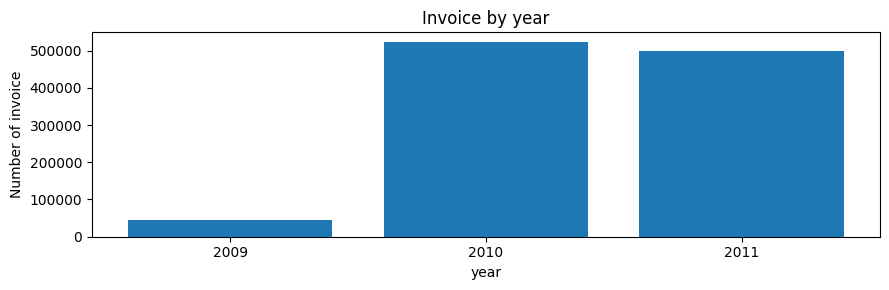

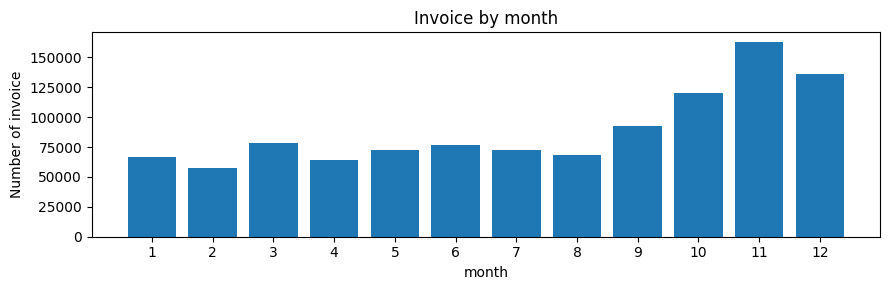

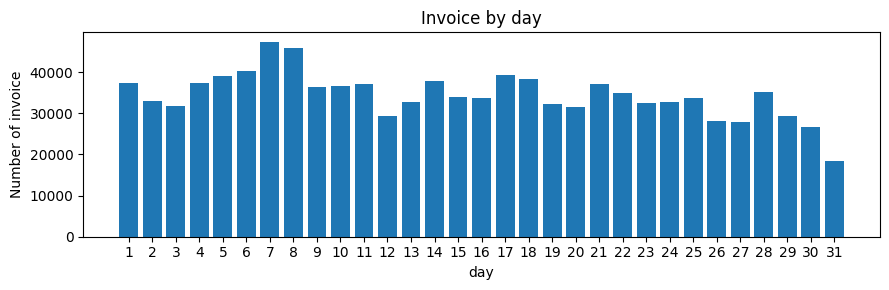

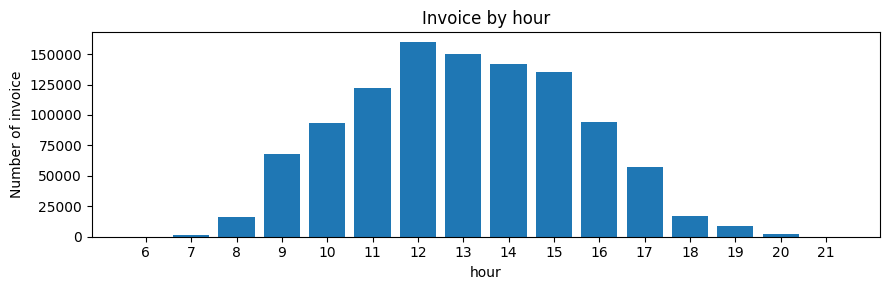

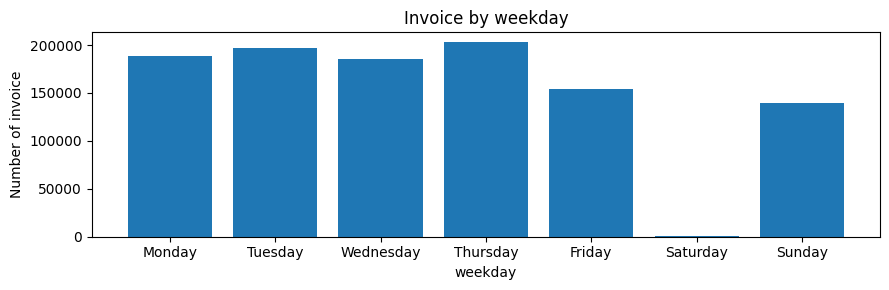

In [18]:
time_columns = ["year", "month", "day", "hour", "weekday"]
for n in time_columns:
    plot_bar(df, n)

In [19]:
heatmap_hourbyweek = df.pivot_table(index="hour", columns="weekday", aggfunc="size")

In [20]:
heatmap_hourbyweek

weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
6,0,0,0,41,0,0,0
7,163,254,181,290,239,0,0
8,3003,2976,3517,3108,3381,0,0
9,15570,13627,11978,13818,13242,0,89
10,17886,16100,15420,17675,17016,30,9121
11,19562,19608,20144,18926,20336,4,23200
12,26151,28628,28791,25802,21369,102,29003
13,27240,27248,25007,25607,19116,102,25988
14,23066,24384,25339,26030,21853,57,20784


Text(0.5, 58.7222222222222, 'Day of Week')

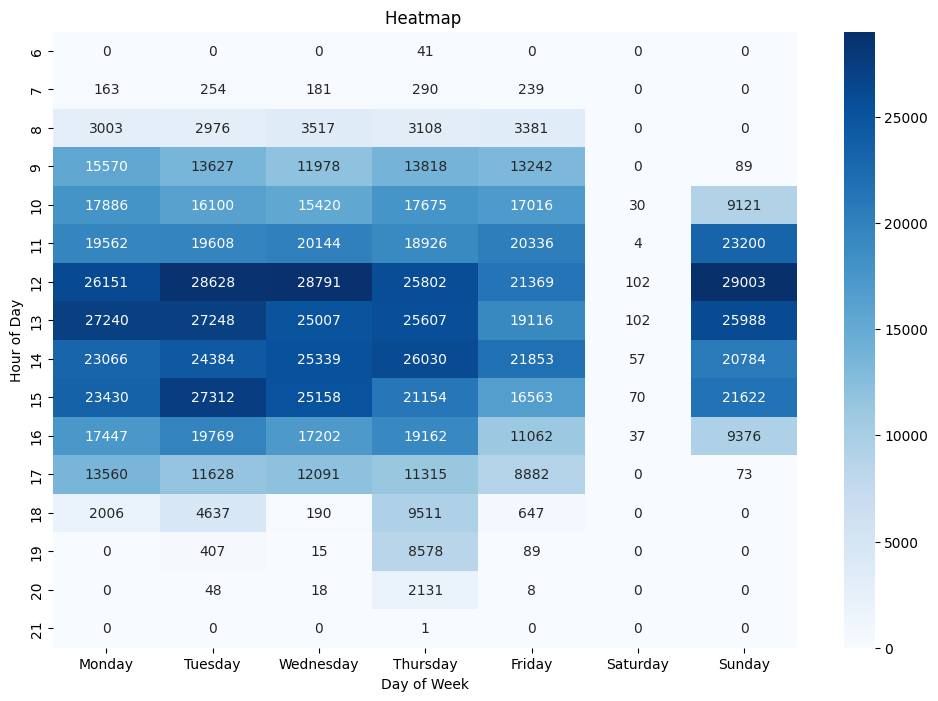

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_hourbyweek, cmap="Blues", annot=True, fmt="d")
plt.title("Heatmap ")
plt.ylabel("Hour of Day")
plt.xlabel("Day of Week")

## Conclusion 
1. 2 cột chưa đúng format data: InvoiceDate (Str --> Datetime) và Customer ID (Float --> Str)
2. 2 cột có missing values là Customer ID và Description
3. Có tới 34335 records duplicates
4. Data ở cột quantity và price lại có giá trị âm, outlier cực lớn


# Cleanning data
1. Drop rows missing Customer ID
2. Format data type of 2 column: Customer ID and InvoiceDate
4. Remove duplicate rows
5. Filter data just get Quantity and Price > 0
6. Add a column "Total Sales" = Quantity * Price

In [22]:
# drop missing value in customer id
df.dropna(subset=['Customer ID'], inplace = True)

In [23]:
# format data type for Customer ID
df['Customer ID'] = df['Customer ID'].astype(str)

In [24]:
# remove duplicate rows
df.drop_duplicates(inplace=True)

In [25]:
# filter data get Quantity and Price > 0
df = df[(df['Price']>0)& (df['Quantity']>0)]

In [26]:
# Add column: "Total Sales"
df['Total Sales'] = df['Price']* df['Quantity']

In [27]:
# More detailed Overview dataset 
overview_df = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Count': [len(df)]*df.shape[1],
    'Unique Values': df.nunique().values,
    'Null Count': df.isnull().sum().values,
    'Zero Count': (df==0).sum().values,
    'Negative Count': (df.apply(pd.to_numeric, errors='coerce') <0).sum().values,
    'Null(%)': df.isnull().mean().round(4).mul(100).values,
    'Zero (%)': (df==0).mean().round(4).mul(100).values,
    'Negative (%)':(df.apply(pd.to_numeric, errors='coerce') <0).mean().round(4).mul(100).values
    
})

overview_df.style\
    .set_properties(**{'font-weight':'bold'}, subset= ['Column'])\
    .set_properties(**{'text-align':'center'})\
    .format(lambda x: f'{x:,.2f}%', subset=['Null(%)','Zero (%)', 'Negative (%)'])

,Column,Data Type,Count,Unique Values,Null Count,Zero Count,Negative Count,Null(%),Zero (%),Negative (%)
0,Invoice,object,779425,36969,0,0,0,0.00%,0.00%,0.00%
1,StockCode,object,779425,4631,0,0,0,0.00%,0.00%,0.00%
2,Description,object,779425,5283,0,0,0,0.00%,0.00%,0.00%
3,Quantity,int64,779425,437,0,0,0,0.00%,0.00%,0.00%
4,InvoiceDate,object,779425,34585,0,0,0,0.00%,0.00%,0.00%
5,Price,float64,779425,665,0,0,0,0.00%,0.00%,0.00%
6,Customer ID,object,779425,5878,0,0,0,0.00%,0.00%,0.00%
7,Country,object,779425,41,0,0,0,0.00%,0.00%,0.00%
8,Invoice Date,datetime64[ns],779425,34585,0,0,0,0.00%,0.00%,0.00%
9,year,int32,779425,3,0,0,0,0.00%,0.00%,0.00%


# Business Analysis

## Product Analysis

In [28]:
# Top 10 product has highest price
price = df.groupby('StockCode', as_index=False)['Price'].agg('max')
price.sort_values('Price', ascending = False).head(10)

,StockCode,Price
4625,M,10953.50
4627,POST,8142.75
4624,DOT,1599.26
1683,22502,649.50
4619,ADJUST,387.54
4620,ADJUST2,358.47
1831,22656,295.00
1830,22655,295.00
1997,22826,195.00
1999,22828,165.00


In [29]:
# Top 10 product has lowest price
price = df.groupby('StockCode', as_index=False)['Price'].agg('min')
price.sort_values('Price', ascending = True).head(10)

,StockCode,Price
4626,PADS,0.001
4621,BANK CHARGES,0.001
49,16053,0.030
137,17061,0.040
41,16045,0.040
62,16162L,0.050
88,16218,0.060
2736,35015,0.060
5,10123G,0.060
40,16044,0.060


In [30]:
# Top 15 products best sell
product_by_quantity = df.groupby(['StockCode', 'Description'], as_index=False)['Quantity'].agg('sum')
product_by_quantity_sorted = product_by_quantity.sort_values('Quantity',ascending = False).head(15)
product_by_quantity_sorted

,StockCode,Description,Quantity
4031,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,105185
4751,85123A,WHITE HANGING HEART T-LIGHT HOLDER,91757
3283,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
4456,84879,ASSORTED COLOUR BIRD ORNAMENT,78234
2781,23166,MEDIUM CERAMIC TOP STORAGE JAR,77916
4725,85099B,JUMBO BAG RED RETROSPOT,74224
115,17003,BROCADE RING PURSE,70082
1357,21977,PACK OF 60 PINK PAISLEY CAKE CASES,54592
4595,84991,60 TEATIME FAIRY CAKE CASES,52828
658,21212,PACK OF 72 RETRO SPOT CAKE CASES,45129


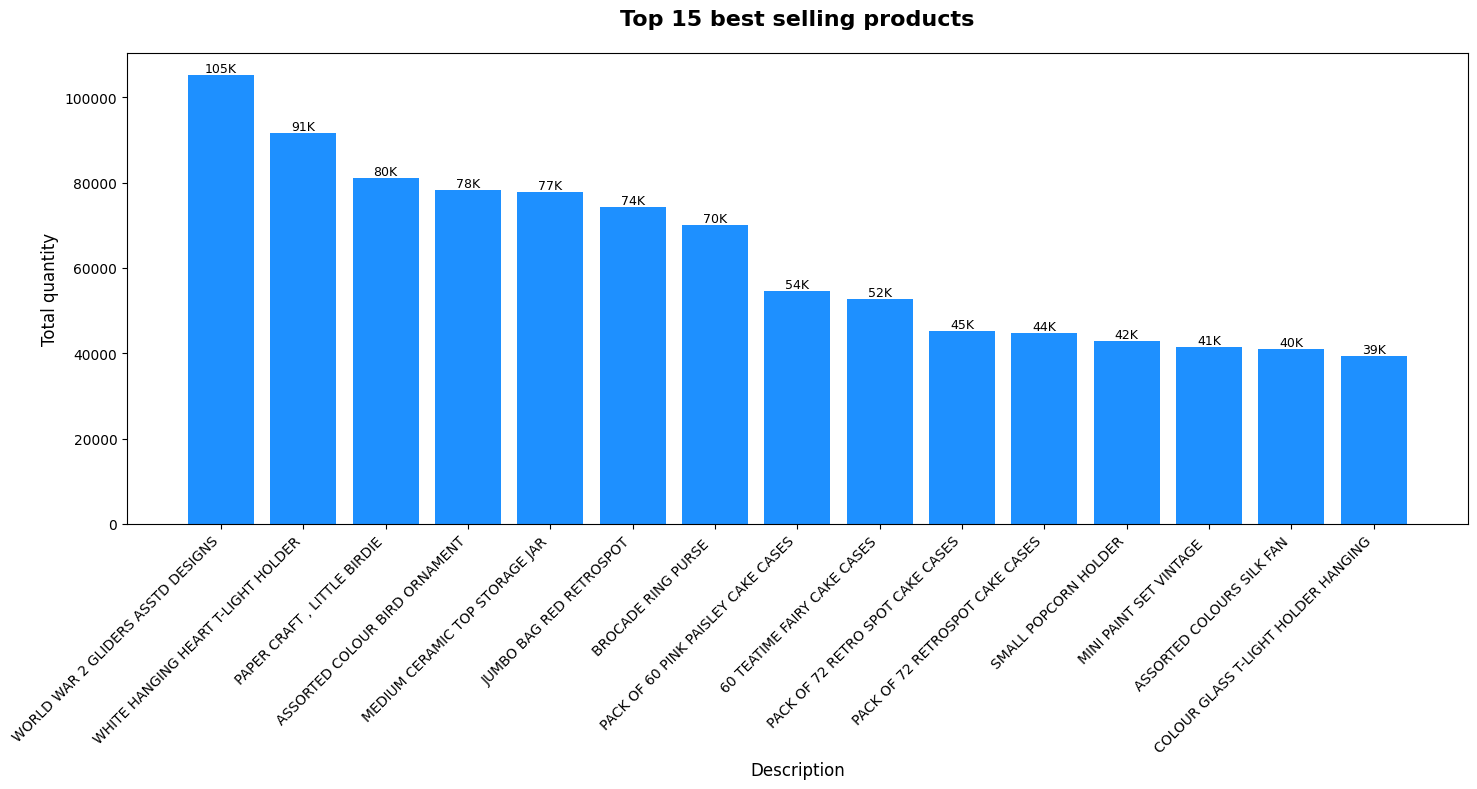

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))

bars = ax.bar(product_by_quantity_sorted['Description'], product_by_quantity_sorted['Quantity'], color='dodgerblue')

ax.set_title('Top 15 best selling products', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Total quantity', fontsize=12)
ax.set_xlabel('Description', fontsize=12)
plt.xticks(rotation=45, ha='right')
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{int(yval/1000)}K', va='bottom', ha='center', fontsize=9)
    
plt.tight_layout()

plt.show()

- Sản phẩm có giá cao nhất là **10953.3** mã sp là M, Description là Manual
- Sản phẩm có giá thấp nhất là 0.001, gồm 2 sản phẩm là Bank Charges và PADS TO MATCH ALL CUSHIONS
- Top 15 sản phẩm bán chạy nhất có 2 sản phẩm phần description khá giống nhau chỉ khác biệt mỗi dấu cách & stock code giống nhau

## Customer Analysis by Total Sales, Country

In [32]:
# Top 15 customers by total sales
customer_by_sales = df.groupby(['Customer ID', 'Country'], as_index = False)['Total Sales'].agg('sum')
customer_by_sales_sorted = customer_by_sales.head(15).sort_values('Total Sales', ascending = False)
customer_by_sales_sorted 

,Customer ID,Country,Total Sales
0,12346.0,United Kingdom,77556.46
11,12357.0,Switzerland,18287.66
13,12359.0,Cyprus,8873.39
10,12356.0,Portugal,6371.73
1,12347.0,Iceland,4921.53
3,12349.0,Italy,4428.69
14,12360.0,Austria,4252.89
12,12358.0,Austria,3887.07
6,12352.0,Norway,2849.84
2,12348.0,Finland,2019.40


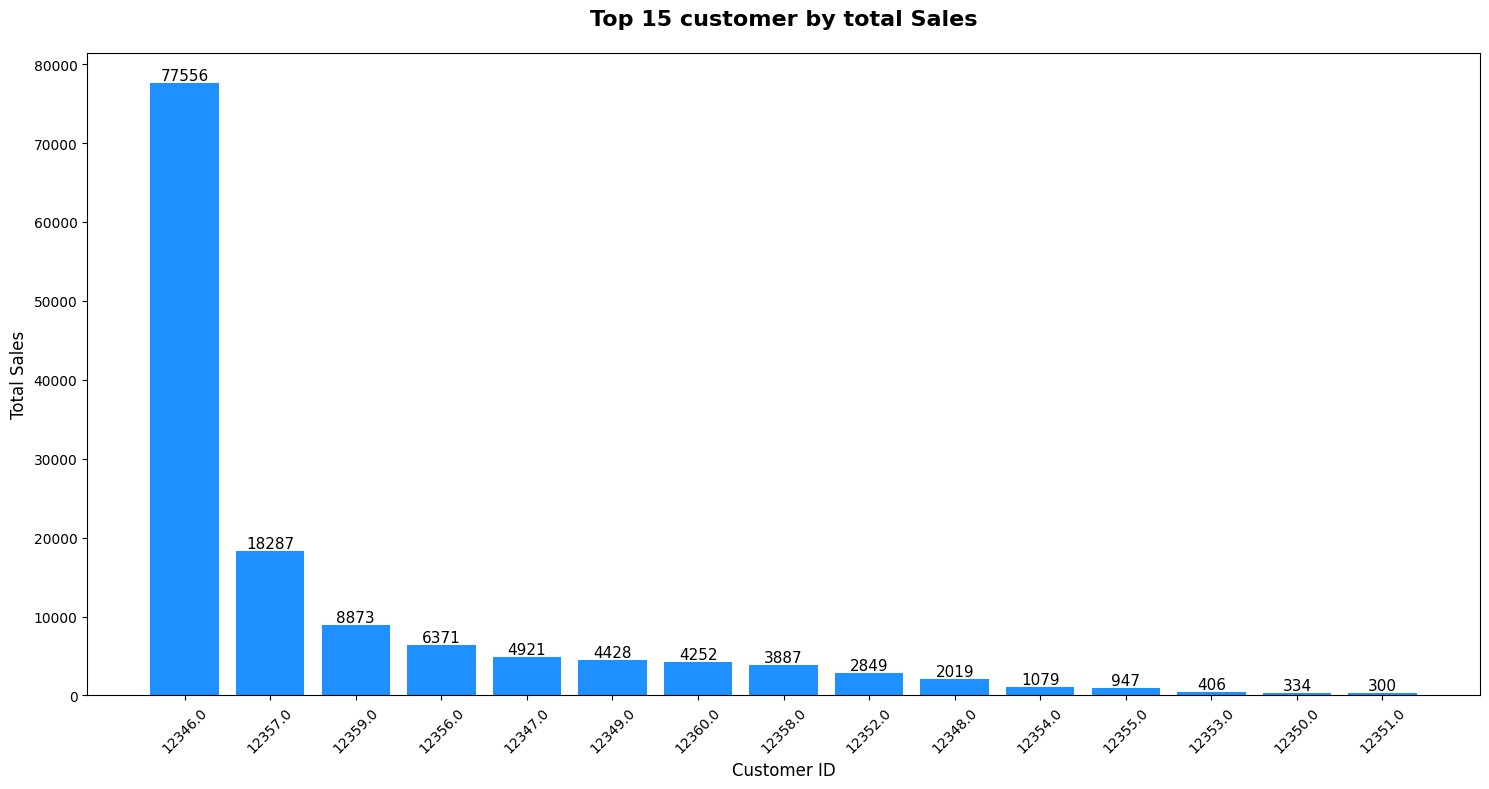

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))

bars = ax.bar(customer_by_sales_sorted['Customer ID'], customer_by_sales_sorted['Total Sales'], color='dodgerblue')

ax.set_title('Top 15 customer by total Sales', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Total Sales', fontsize=12)
ax.set_xlabel('Customer ID', fontsize=12)
for bar in bars:
    y_value = bar.get_height()
    x_value = bar.get_x() + bar.get_width() / 2.0
    ax.text(x_value, y_value, int(y_value), va='bottom', ha='center', fontsize=11, color='black')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [34]:
# Number of customer by county
customer_by_country = df.groupby('Country', as_index = False)['Customer ID'].nunique()
customer_by_country_sorted = customer_by_country.sort_values('Customer ID',ascending=False).head(15)
customer_by_country_sorted 

,Country,Customer ID
38,United Kingdom,5350
14,Germany,107
13,France,95
32,Spain,41
3,Belgium,29
28,Portugal,24
34,Switzerland,22
24,Netherlands,22
33,Sweden,19
18,Italy,17


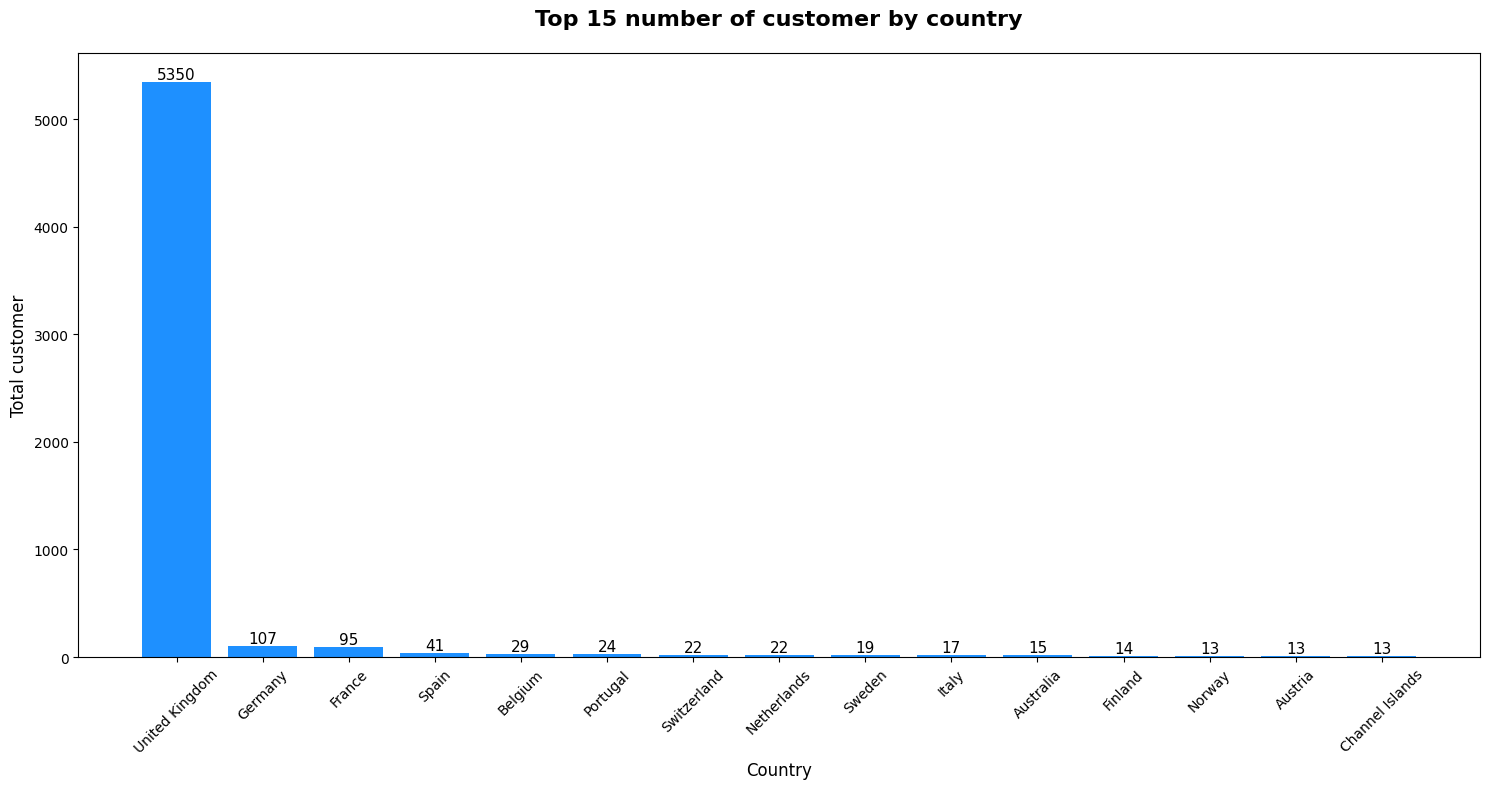

In [35]:
fig, ax = plt.subplots(figsize=(15, 8))

bars = ax.bar(customer_by_country_sorted['Country'], customer_by_country_sorted['Customer ID'], color='dodgerblue')

ax.set_title('Top 15 number of customer by country', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Total customer', fontsize=12)
ax.set_xlabel('Country', fontsize=12)
for bar in bars:
    y_value = bar.get_height()
    x_value = bar.get_x() + bar.get_width() / 2.0
    ax.text(x_value, y_value, int(y_value), va='bottom', ha='center', fontsize=11, color='black')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

- Các khách hàng chủ yếu đến từ UK, tuy nhiên chỉ có khách hàng dành nhiều tiền mua hàng nhất là đến từ UK, còn 14 khách hàng tiếp theo lại đến từ các nước khác

## Country Analysis by Total Sales

In [36]:
# Top 15 country by total sales
country_by_sales = df.groupby('Country', as_index = False)['Total Sales'].agg('sum')
country_by_sales_sorted = country_by_sales.sort_values('Total Sales', ascending=False).head(15)
country_by_sales_sorted

,Country,Total Sales
38,United Kingdom,1.438923e+07
10,EIRE,6.165705e+05
24,Netherlands,5.540381e+05
14,Germany,4.250197e+05
13,France,3.487690e+05
0,Australia,1.692835e+05
32,Spain,1.083325e+05
34,Switzerland,1.000619e+05
33,Sweden,9.151582e+04
9,Denmark,6.858069e+04


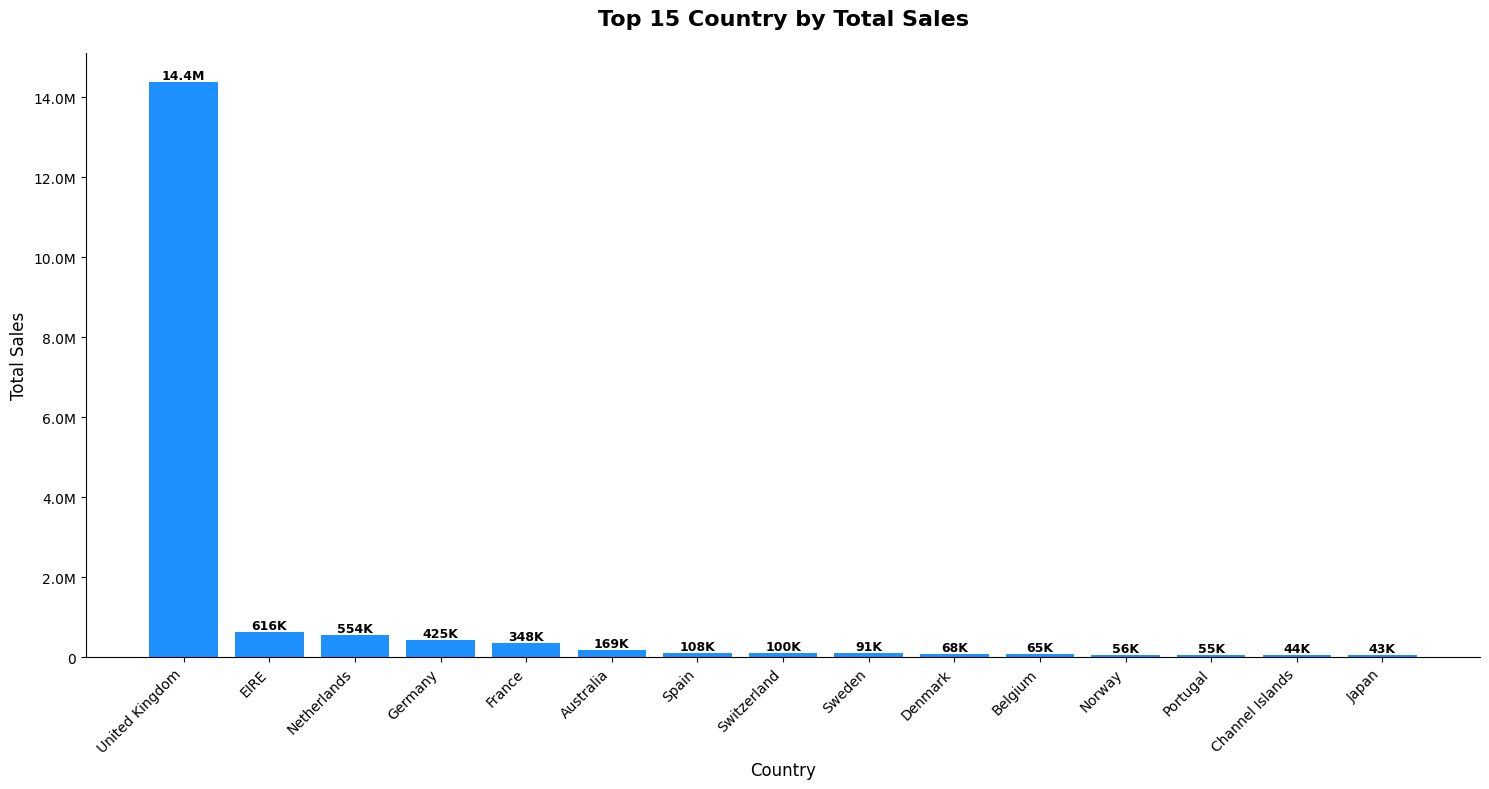

In [37]:
countries = country_by_sales_sorted['Country']
sales = country_by_sales_sorted['Total Sales']

# Tạo một hàm để định dạng số cho đẹp
def format_sales(value):
    if value >= 1_000_000:
        # Định dạng thành triệu (M) với 1 chữ số thập phân
        return f'{value / 1_000_000:.1f}M'
    elif value >= 1_000:
        # Định dạng thành nghìn (K) với 0 chữ số thập phân
        return f'{int(value / 1_000)}K'
    else:
        return f'{int(value)}'

# 1. Vẽ biểu đồ cột
fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(countries, sales, color='dodgerblue')

# 2. Tùy chỉnh tiêu đề và các trục
ax.set_title('Top 15 Country by Total Sales', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Total Sales', fontsize=12)
ax.set_xlabel('Country', fontsize=12)
plt.xticks(rotation=45, ha='right') # Xoay chéo nhãn để dễ đọc

# Ẩn trục Y vì chúng ta sẽ dùng nhãn dữ liệu
# ax.get_yaxis().set_visible(False)
# Thay vào đó, chúng ta có thể format trục Y
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format_sales(x)))


# 3. PHẦN QUAN TRỌNG: Thêm và định dạng nhãn dữ liệu
for bar in bars:
    y_value = bar.get_height()
    
    # Sử dụng hàm format_sales để tạo nhãn đẹp
    label = format_sales(y_value)
    
    ax.text(bar.get_x() + bar.get_width() / 2, y_value, label,
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Tinh chỉnh bố cục
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# 5. Hiển thị biểu đồ
plt.show()

## Time Analysis

In [38]:
# Total Sales by Year
sales_by_year = df.groupby('year', as_index = False)['Total Sales'].agg('sum')
sales_by_year

,year,Total Sales
0,2009,683504.010
1,2010,8374496.094
2,2011,8316804.164


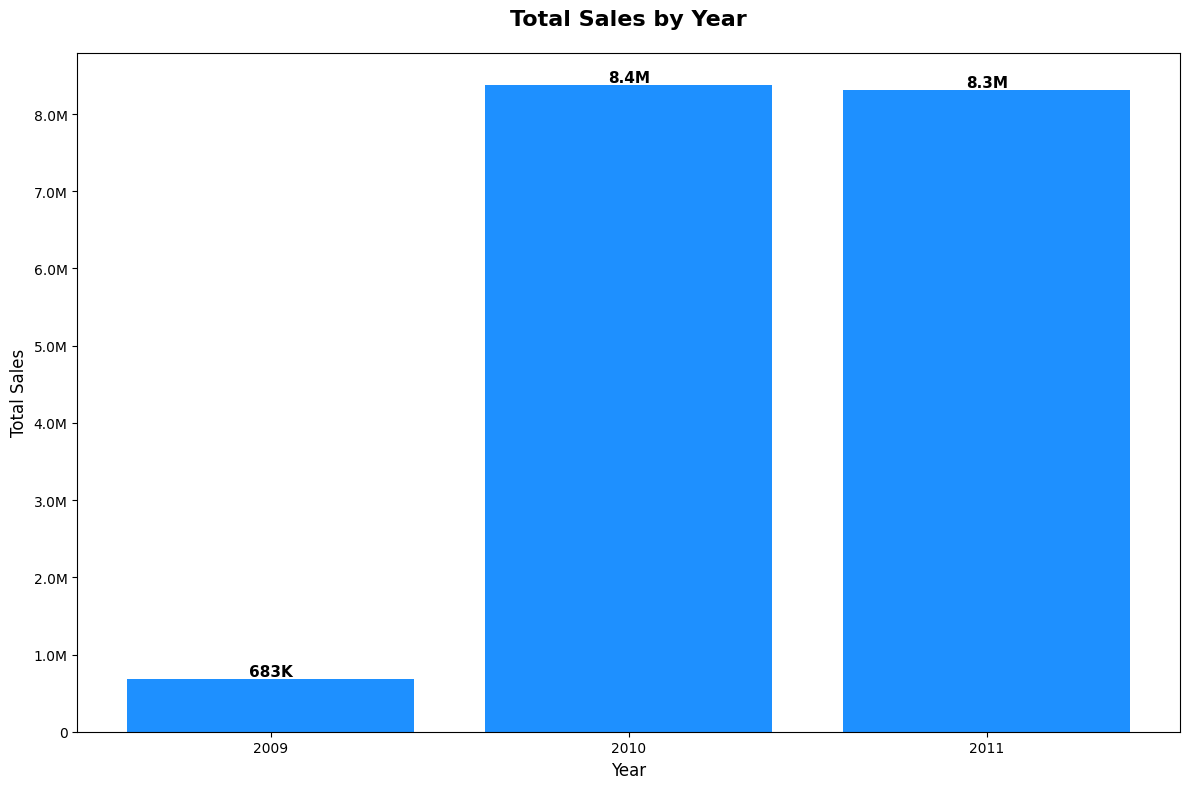

In [39]:
plot_data = sales_by_year.copy()
plot_data['year'] = plot_data['year'].astype(str)
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(plot_data['year'], plot_data['Total Sales'], color='dodgerblue')

ax.set_title('Total Sales by Year', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Total Sales', fontsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format_sales(x)))
for bar in bars:
    y_value = bar.get_height()
    label = format_sales(y_value)
    ax.text(bar.get_x() + bar.get_width() / 2, y_value, label,
            ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

In [40]:
# Monthly Customer
df_copy = df.copy()
df_copy['month']=df_copy['Invoice Date'].dt.strftime('%Y-%m')
df_copy['month'].unique()

array(['2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
       '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12'], dtype=object)

In [41]:
# number of invoice by monthly
count_tr = df_copy.groupby(['month'], as_index = False)['Invoice'].agg('count')
print(count_tr)

      month  Invoice
0   2009-12    30272
1   2010-01    21458
2   2010-02    23040
3   2010-03    31782
4   2010-04    26831
5   2010-05    28233
6   2010-06    30688
7   2010-07    26643
8   2010-08    26029
9   2010-09    34128
10  2010-10    48723
11  2010-11    58905
12  2010-12    25670
13  2011-01    20988
14  2011-02    19706
15  2011-03    26870
16  2011-04    22433
17  2011-05    28073
18  2011-06    26926
19  2011-07    26580
20  2011-08    26790
21  2011-09    39669
22  2011-10    48793
23  2011-11    63168
24  2011-12    17027


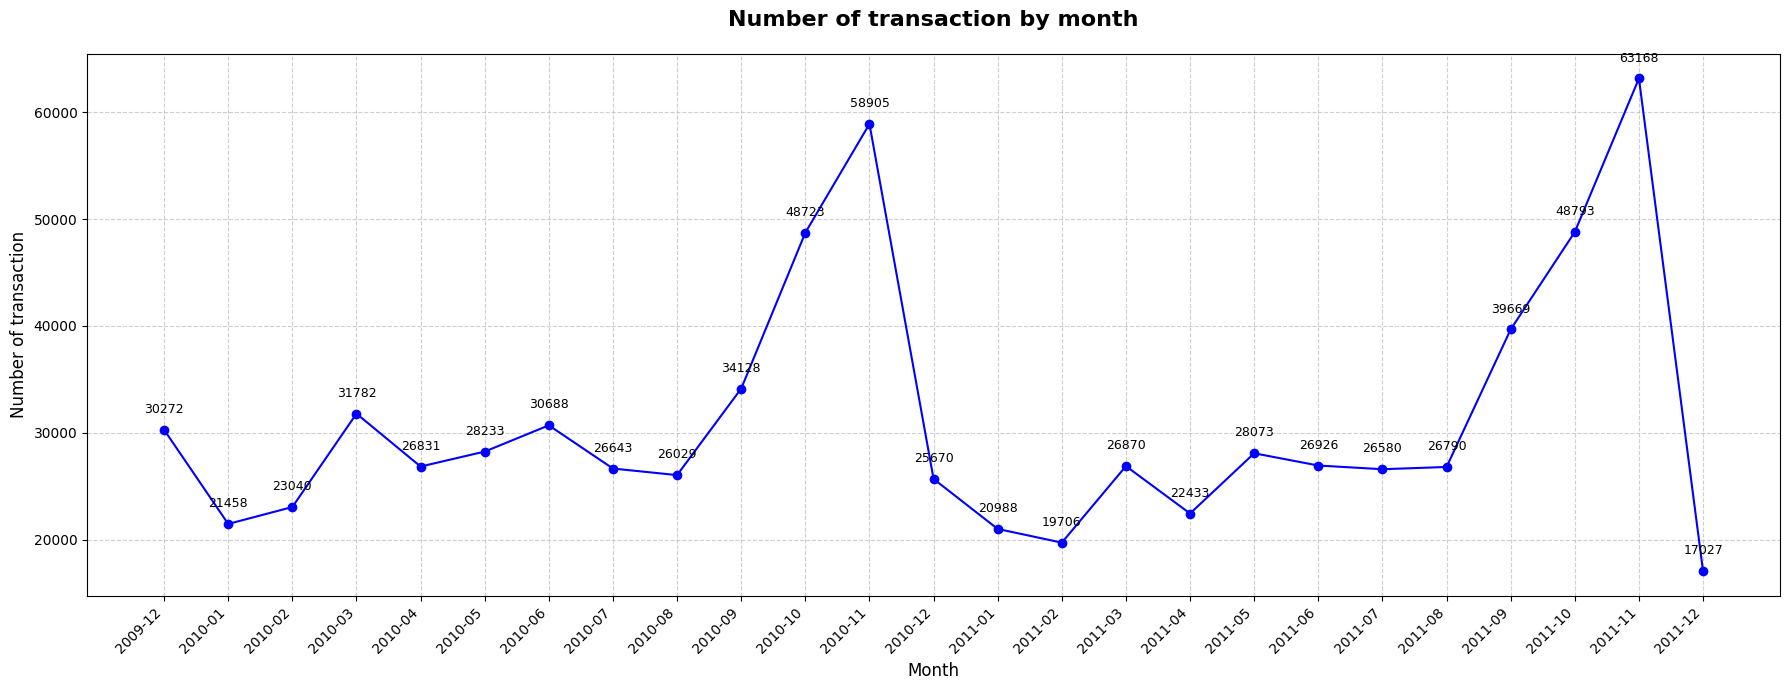

In [42]:
fig, ax = plt.subplots(figsize=(18, 7))

# 2. Vẽ biểu đồ đường
# Trục x là 'month', trục y là 'Invoice'
# Thêm marker='o' để làm nổi bật các điểm dữ liệu hàng tháng
ax.plot(count_tr['month'], count_tr['Invoice'], marker='o', linestyle='-', color='b')

# 3. Tùy chỉnh tiêu đề và các trục
ax.set_title('Number of transaction by month', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Number of transaction', fontsize=12)
ax.set_xlabel('Month', fontsize=12)

# 4. Tinh chỉnh các nhãn trên trục X để dễ đọc hơn
# Xoay nhãn một góc để tránh chồng chéo
plt.xticks(rotation=45, ha='right')
for index, row in count_tr.iterrows():
    month = row['month']
    invoice_count = row['Invoice']
    label = invoice_count
    # Dùng ax.annotate để thêm text
    ax.annotate(label,                    # Text cần hiển thị
                xy=(month, invoice_count), # Vị trí của điểm cần chú thích
                xytext=(0, 10),           # Độ lệch của text so với điểm (0 ngang, 10 điểm dọc)
                textcoords='offset points', # Hệ tọa độ cho xytext
                ha='center',              # Căn lề ngang
                va='bottom',              # Căn lề dọc
                fontsize=9,
                fontweight='medium')

# 5. Thêm lưới (grid) để dễ dàng gióng các giá trị
ax.grid(True, linestyle='--', alpha=0.6)

# 6. Đảm bảo bố cục vừa vặn
plt.tight_layout()

# 7. Hiển thị biểu đồ
plt.show()

In [43]:
# number of customer by month
customer_by_month = df_copy.groupby(['month'], as_index=False)['Customer ID'].nunique()
customer_by_month


,month,Customer ID
0,2009-12,955
1,2010-01,720
2,2010-02,772
3,2010-03,1057
4,2010-04,942
5,2010-05,966
6,2010-06,1041
7,2010-07,928
8,2010-08,911
9,2010-09,1145


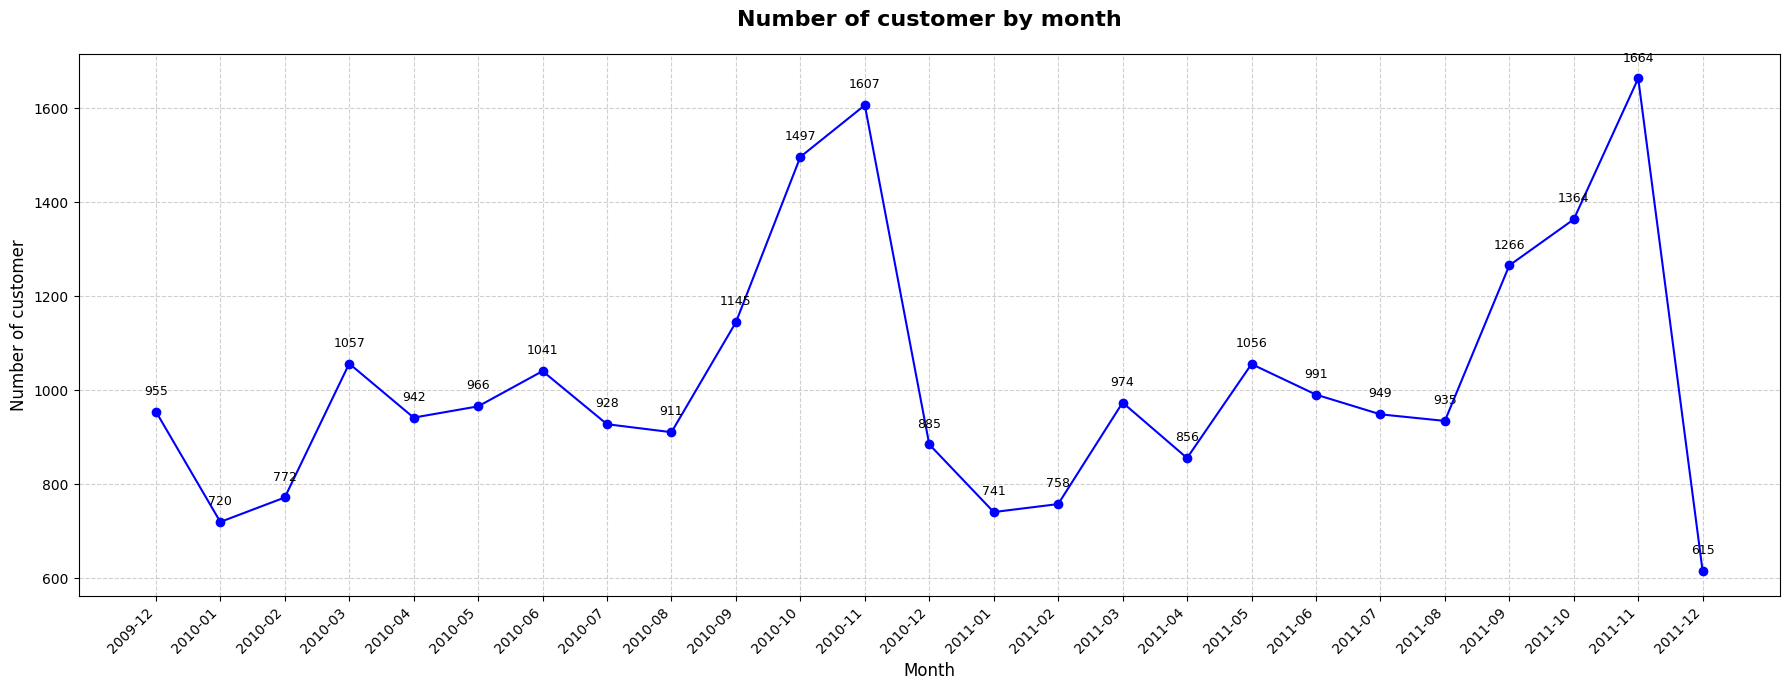

In [44]:
fig, ax = plt.subplots(figsize=(18, 7))

# 2. Vẽ biểu đồ đường
# Trục x là 'month', trục y là 'Invoice'
# Thêm marker='o' để làm nổi bật các điểm dữ liệu hàng tháng
ax.plot(customer_by_month['month'], customer_by_month['Customer ID'], marker='o', linestyle='-', color='b')

# 3. Tùy chỉnh tiêu đề và các trục
ax.set_title('Number of customer by month', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Number of customer', fontsize=12)
ax.set_xlabel('Month', fontsize=12)

# 4. Tinh chỉnh các nhãn trên trục X để dễ đọc hơn
# Xoay nhãn một góc để tránh chồng chéo
plt.xticks(rotation=45, ha='right')
for index, row in customer_by_month.iterrows():
    month = row['month']
    customer_count = row['Customer ID']
    label = customer_count
    # Dùng ax.annotate để thêm text
    ax.annotate(label,                    # Text cần hiển thị
                xy=(month, customer_count), # Vị trí của điểm cần chú thích
                xytext=(0, 10),           # Độ lệch của text so với điểm (0 ngang, 10 điểm dọc)
                textcoords='offset points', # Hệ tọa độ cho xytext
                ha='center',              # Căn lề ngang
                va='bottom',              # Căn lề dọc
                fontsize=9,
                fontweight='medium')

# 5. Thêm lưới (grid) để dễ dàng gióng các giá trị
ax.grid(True, linestyle='--', alpha=0.6)

# 6. Đảm bảo bố cục vừa vặn
plt.tight_layout()

# 7. Hiển thị biểu đồ
plt.show()

# Cohort analysis by quarter
- In 2009, data just have December --> don't get it

In [45]:
# no get data in December 2009
df = df[df['Invoice Date'].dt.year != 2009]

In [46]:
# Create cohort quarter
df['InvoiceQuarter'] = df['Invoice Date'].dt.to_period('Q')

df['CohortQuarter'] = df.groupby('Customer ID')['InvoiceQuarter'].transform('min')

df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Invoice Date,year,month,day,weekday,hour,Total Sales,InvoiceQuarter,CohortQuarter
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09 12:50:00,2011,12,9,Friday,12,12.60,2011Q4,2011Q3
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09 12:50:00,2011,12,9,Friday,12,16.60,2011Q4,2011Q3
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09 12:50:00,2011,12,9,Friday,12,16.60,2011Q4,2011Q3
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-09 12:50:00,2011,12,9,Friday,12,14.85,2011Q4,2011Q3
1067370,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,2011-12-09 12:50:00,2011,12,9,Friday,12,18.00,2011Q4,2011Q3


In [47]:
# Create cohort index
invoice_year = df['InvoiceQuarter'].dt.year
invoice_quarter = df['InvoiceQuarter'].dt.quarter

cohort_year = df['CohortQuarter'].dt.year
cohort_quarter = df['CohortQuarter'].dt.quarter

year_diff = invoice_year - cohort_year
quarter_diff = invoice_quarter - cohort_quarter

df['CohortIndex'] = year_diff * 4 + quarter_diff + 1
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Invoice Date,year,month,day,weekday,hour,Total Sales,InvoiceQuarter,CohortQuarter,CohortIndex
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0,United Kingdom,2010-01-04 09:24:00,2010,1,4,Monday,9,22.5,2010Q1,2010Q1,1
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0,United Kingdom,2010-01-04 09:53:00,2010,1,4,Monday,9,22.5,2010Q1,2010Q1,1
45234,493414,21844,RETRO SPOT MUG,36,2010-01-04 10:28:00,2.55,14590.0,United Kingdom,2010-01-04 10:28:00,2010,1,4,Monday,10,91.8,2010Q1,2010Q1,1
45235,493414,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-04 10:28:00,4.25,14590.0,United Kingdom,2010-01-04 10:28:00,2010,1,4,Monday,10,51.0,2010Q1,2010Q1,1
45236,493414,37508,NEW ENGLAND CERAMIC CAKE SERVER,2,2010-01-04 10:28:00,2.55,14590.0,United Kingdom,2010-01-04 10:28:00,2010,1,4,Monday,10,5.1,2010Q1,2010Q1,1
45237,493414,35001G,HAND OPEN SHAPE GOLD,2,2010-01-04 10:28:00,4.25,14590.0,United Kingdom,2010-01-04 10:28:00,2010,1,4,Monday,10,8.5,2010Q1,2010Q1,1
45238,493414,21527,RETRO SPOT TRADITIONAL TEAPOT,12,2010-01-04 10:28:00,6.95,14590.0,United Kingdom,2010-01-04 10:28:00,2010,1,4,Monday,10,83.4,2010Q1,2010Q1,1
45239,493414,21531,RETRO SPOT SUGAR JAM BOWL,24,2010-01-04 10:28:00,2.10,14590.0,United Kingdom,2010-01-04 10:28:00,2010,1,4,Monday,10,50.4,2010Q1,2010Q1,1
45242,493427,82483,WOOD 2 DRAWER CABINET WHITE FINISH,4,2010-01-04 10:43:00,5.95,13287.0,United Kingdom,2010-01-04 10:43:00,2010,1,4,Monday,10,23.8,2010Q1,2010Q1,1
45243,493427,21681,GIANT MEDINA STAMPED METAL BOWL,2,2010-01-04 10:43:00,9.95,13287.0,United Kingdom,2010-01-04 10:43:00,2010,1,4,Monday,10,19.9,2010Q1,2010Q1,1


In [48]:
# Create pivot table: count number of customer
cohort_retention = df.groupby(['CohortQuarter', 'CohortIndex'])['Customer ID'].apply(pd.Series.nunique).reset_index()
cohort_retention.rename(columns={'Customer ID': 'Customer Count'}, inplace=True)
cohort_counts = cohort_retention.pivot(index='CohortQuarter',
                                 columns ='CohortIndex',
                                 values = 'Customer Count')
cohort_retention.head()

,CohortQuarter,CohortIndex,Customer Count
0,2010Q1,1,1803
1,2010Q1,2,1093
2,2010Q1,3,1033
3,2010Q1,4,1093
4,2010Q1,5,834


In [49]:
# Convert retention into percentage
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention_rate = retention.round(4)*100

In [50]:
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8
CohortQuarter,,,,,,,,
2010Q1,1803.0,1093.0,1033.0,1093.0,834.0,833.0,836.0,828.0
2010Q2,954.0,386.0,453.0,223.0,316.0,280.0,320.0,NaN
2010Q3,641.0,291.0,166.0,169.0,207.0,206.0,NaN,NaN
2010Q4,833.0,170.0,194.0,170.0,294.0,NaN,NaN,NaN
2011Q1,383.0,152.0,125.0,135.0,NaN,NaN,NaN,NaN
2011Q2,327.0,140.0,128.0,NaN,NaN,NaN,NaN,NaN
2011Q3,403.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN
2011Q4,445.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
retention_rate

CohortIndex,1,2,3,4,5,6,7,8
CohortQuarter,,,,,,,,
2010Q1,100.0,60.62,57.29,60.62,46.26,46.20,46.37,45.92
2010Q2,100.0,40.46,47.48,23.38,33.12,29.35,33.54,NaN
2010Q3,100.0,45.40,25.90,26.37,32.29,32.14,NaN,NaN
2010Q4,100.0,20.41,23.29,20.41,35.29,NaN,NaN,NaN
2011Q1,100.0,39.69,32.64,35.25,NaN,NaN,NaN,NaN
2011Q2,100.0,42.81,39.14,NaN,NaN,NaN,NaN,NaN
2011Q3,100.0,50.62,NaN,NaN,NaN,NaN,NaN,NaN
2011Q4,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


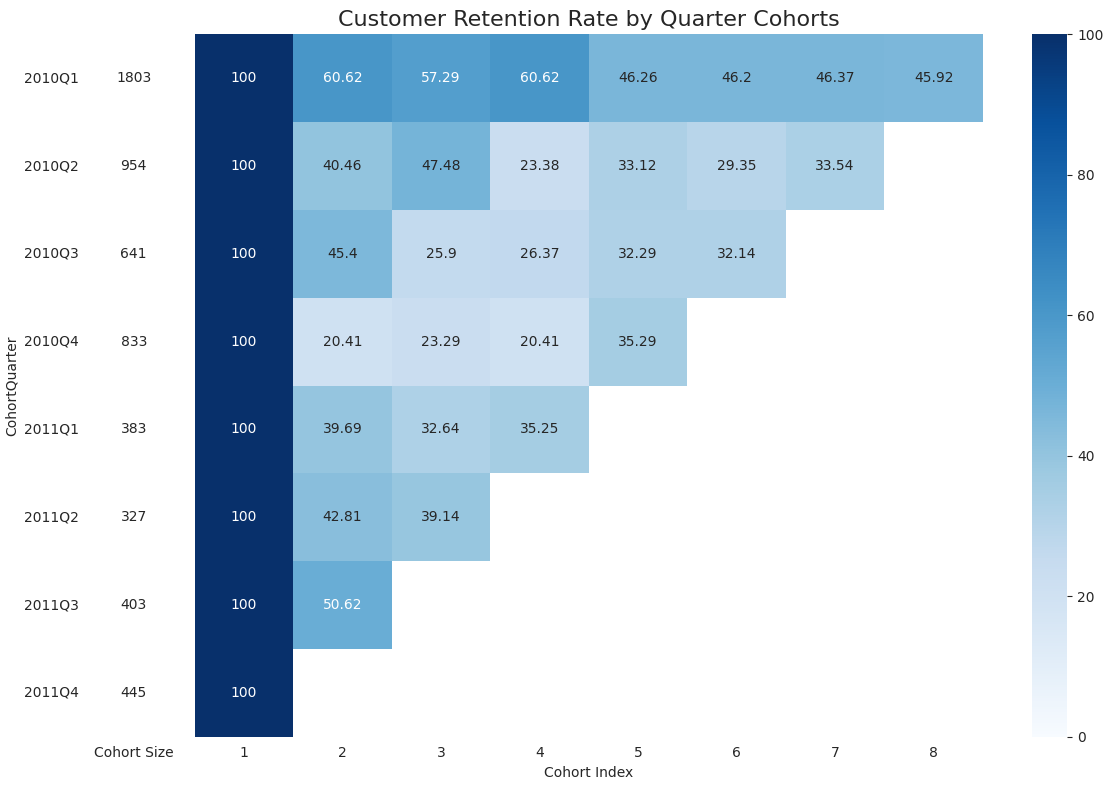

In [52]:
# visualization 
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    custom_cmap = sns.color_palette("Blues", as_cmap=True) 
    sns.heatmap(retention_rate, 
                mask=retention_rate.isnull(), 
                annot=True, 
                fmt='g', 
                cmap=custom_cmap,
                vmin=0.0,
                vmax=100,
                ax=ax[1])
    ax[1].set_title('Customer Retention Rate by Quarter Cohorts', fontsize=16)
    ax[1].set(xlabel='Cohort Index',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_sizes).rename(columns={1: 'Cohort Size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])
    ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0, ha='right')

    fig.tight_layout()
    
plt.show()

# CLTV Prediction

## BG-NBD and GG Models

### Prepare Data

In [70]:
#Split data for train - test
holdout_days = 90 
calibration_period_end = df['Invoice Date'].max() - pd.DateOffset(days=holdout_days)

calibration_df = df[df['Invoice Date'] <= calibration_period_end]
holdout_df = df[df['Invoice Date'] > calibration_period_end]

In [71]:
#Prepare CLTV dataframe for train dataset
cltv_data_cal = calibration_df.groupby('Customer ID').agg(
    {'Invoice Date': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days, #Rencecy
                     lambda InvoiceDate: (calibration_period_end - InvoiceDate.min()).days], #Tenure
     'Invoice': lambda Invoice: Invoice.nunique(), #frequency
     'Total Sales': lambda TotalSales: TotalSales.sum()}) # monetary
cltv_data_cal.columns = cltv_data_cal.columns.droplevel(0)
cltv_data_cal.columns = ['recency_cal', 'T_cal', 'frequency_cal', 'monetary_cal']

## Calculate average monetary value - yêu cầu đầu vào của mô hình GammaGamma
cltv_data_cal["monetary_cal"] = cltv_data_cal["monetary_cal"] / cltv_data_cal["frequency_cal"]

# Filter customers frequency >1 - Bởi vì cần dự đoán khách hàng mua lại, bộ dữ liệu hiện tại bao gồm tất cả khách hàng
cltv_data_cal = cltv_data_cal[(cltv_data_cal['frequency_cal'] > 1)]

cltv_data_cal.head()

,recency_cal,T_cal,frequency_cal,monetary_cal
Customer ID,,,,
12346.0,379,614,7,11063.280
12347.0,274,313,6,567.065
12348.0,189,347,4,427.350
12349.0,181,498,3,890.380
12352.0,130,302,7,272.230


In [72]:
#Caculate metrics for test dataset
cltv_holdout = holdout_df.groupby('Customer ID').agg({'Invoice': lambda Invoice: Invoice.nunique(), #frequency
                                                           'Total Sales': lambda TotalSales: TotalSales.sum()
                                                          })
cltv_holdout.columns = ['frequency_holdout', 'CLTV_holdout']
cltv_holdout["monetary_holdout"] = cltv_holdout["CLTV_holdout"] / cltv_holdout["frequency_holdout"]
cltv_holdout.head(5)

,frequency_holdout,CLTV_holdout,monetary_holdout
Customer ID,,,
12347.0,2,1519.14,759.570000
12348.0,1,310.00,310.000000
12349.0,1,1757.55,1757.550000
12352.0,3,944.23,314.743333
12356.0,1,58.35,58.350000


In [73]:
#Merge 2 dataframe train và test
final_cltv_data = pd.merge(cltv_data_cal, cltv_holdout, on='Customer ID', how='left')

final_cltv_data.fillna(0, inplace=True)
final_cltv_data = final_cltv_data.astype({'frequency_holdout': 'int64'})
final_cltv_data['duration_holdout'] = holdout_days
final_cltv_data.head()

,recency_cal,T_cal,frequency_cal,monetary_cal,frequency_holdout,CLTV_holdout,monetary_holdout,duration_holdout
Customer ID,,,,,,,,
12346.0,379,614,7,11063.280,0,0.00,0.000000,90
12347.0,274,313,6,567.065,2,1519.14,759.570000,90
12348.0,189,347,4,427.350,1,310.00,310.000000,90
12349.0,181,498,3,890.380,1,1757.55,1757.550000,90
12352.0,130,302,7,272.230,3,944.23,314.743333,90


### Modelling

In [74]:
#Kiểm định giả định GammaGamma
correlation = final_cltv_data[['frequency_cal', 'monetary_cal']].corr().iloc[0, 1]
print(f"\nTương quan trên tập calibration thủ công: {correlation:.4f}")


Tương quan trên tập calibration thủ công: 0.0879


In [75]:
#Train model BG/NBD
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(
    final_cltv_data['frequency_cal'],
    final_cltv_data['recency_cal'],
    final_cltv_data['T_cal']
)

<lifetimes.BetaGeoFitter: fitted with 3619 subjects, a: 0.39, alpha: 78.81, b: 3.50, r: 1.89>

In [76]:
#Train model GammaGamma
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(
    final_cltv_data['frequency_cal'], 
    final_cltv_data['monetary_cal']
)

<lifetimes.GammaGammaFitter: fitted with 3619 subjects, p: 12.37, q: 0.95, v: 12.27>

In [77]:
# get predicted frequency during holdout period
predicted_frequency = bgf.predict(
    holdout_days,
    final_cltv_data['frequency_cal'],
    final_cltv_data['recency_cal'],
    final_cltv_data['T_cal']
)
final_cltv_data['predicted_frequency_holdout'] = predicted_frequency
final_cltv_data[['frequency_holdout', 'predicted_frequency_holdout']].head()

,frequency_holdout,predicted_frequency_holdout
Customer ID,,
12346.0,0,0.428666
12347.0,2,1.579065
12348.0,1,0.625955
12349.0,1,0.165178
12352.0,3,0.210852


In [78]:
#get predicted monetary value during holdout period
predicted_monetary = ggf.conditional_expected_average_profit(
    final_cltv_data ['frequency_cal'],
    final_cltv_data ['monetary_cal']
)
final_cltv_data['predicted_monetary_holdout'] = predicted_monetary
final_cltv_data[['monetary_holdout', 'predicted_monetary_holdout']].head()

,monetary_holdout,predicted_monetary_holdout
Customer ID,,
12346.0,0.000000,11071.395210
12347.0,759.570000,569.491368
12348.0,310.000000,430.850116
12349.0,1757.550000,895.670132
12352.0,314.743333,274.140005


In [79]:
#Kết hợp cả 2 model
predicted_CLTV = ggf.customer_lifetime_value(
    bgf, # Mô hình BG/NBD đã huấn luyện
    final_cltv_data['frequency_cal'],
    final_cltv_data['recency_cal'],
    final_cltv_data['T_cal'],
    final_cltv_data['monetary_cal'],
    time=holdout_days, 
    freq='D',       
    discount_rate=0.01 
)

final_cltv_data['predicted_CLTV'] = predicted_CLTV
final_cltv_data.head()

,recency_cal,T_cal,frequency_cal,monetary_cal,frequency_holdout,CLTV_holdout,monetary_holdout,duration_holdout,predicted_frequency_holdout,predicted_monetary_holdout,predicted_CLTV
Customer ID,,,,,,,,,,,
12346.0,379,614,7,11063.280,0,0.00,0.000000,90,0.428666,11071.395210,70071.060547
12347.0,274,313,6,567.065,2,1519.14,759.570000,90,1.579065,569.491368,11986.418643
12348.0,189,347,4,427.350,1,310.00,310.000000,90,0.625955,430.850116,3676.014491
12349.0,181,498,3,890.380,1,1757.55,1757.550000,90,0.165178,895.670132,2141.265157
12352.0,130,302,7,272.230,3,944.23,314.743333,90,0.210852,274.140005,764.465953


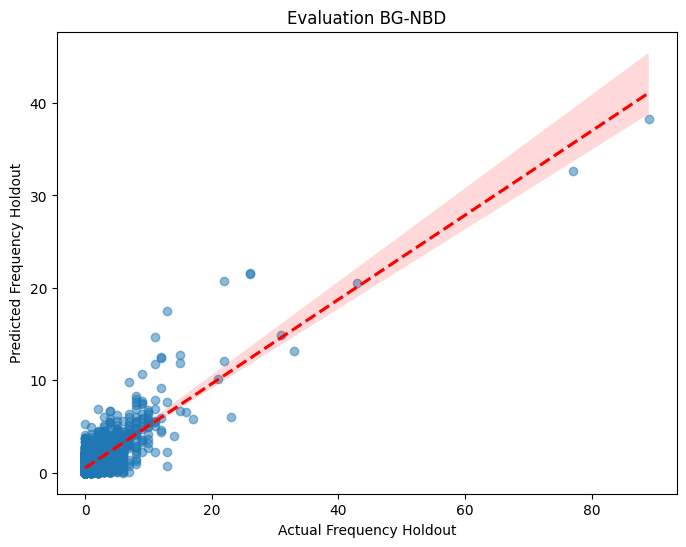

In [80]:
plt.figure(figsize=(8, 6))
sns.regplot(x='frequency_holdout', y='predicted_frequency_holdout', data=final_cltv_data,
            line_kws={'color': 'red', 'linestyle': '--'}, scatter_kws={'alpha': 0.5})
plt.xlabel("Actual Frequency Holdout")
plt.ylabel("Predicted Frequency Holdout")
plt.title("Evaluation BG-NBD")
plt.show()

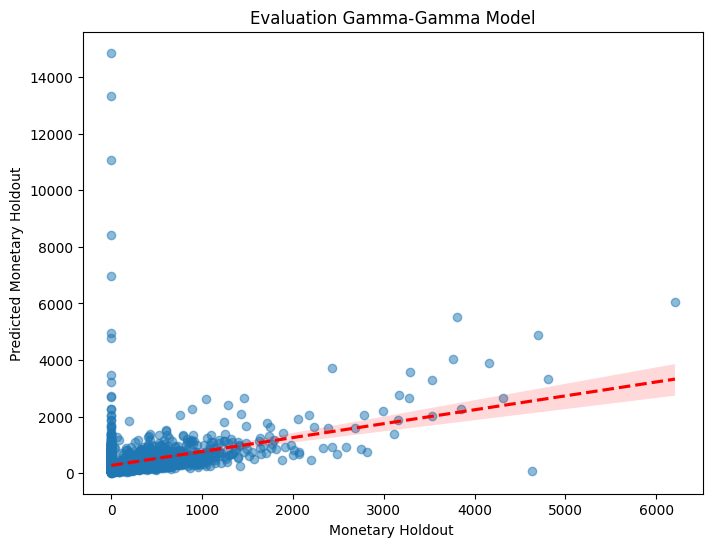

In [81]:
plt.figure(figsize=(8, 6))
sns.regplot(x='monetary_holdout', y='predicted_monetary_holdout', data=final_cltv_data,
            line_kws={'color': 'red', 'linestyle': '--'}, scatter_kws={'alpha': 0.5})
plt.xlabel("Monetary Holdout ")
plt.ylabel("Predicted Monetary Holdout")
plt.title("Evaluation Gamma-Gamma Model")
plt.show()

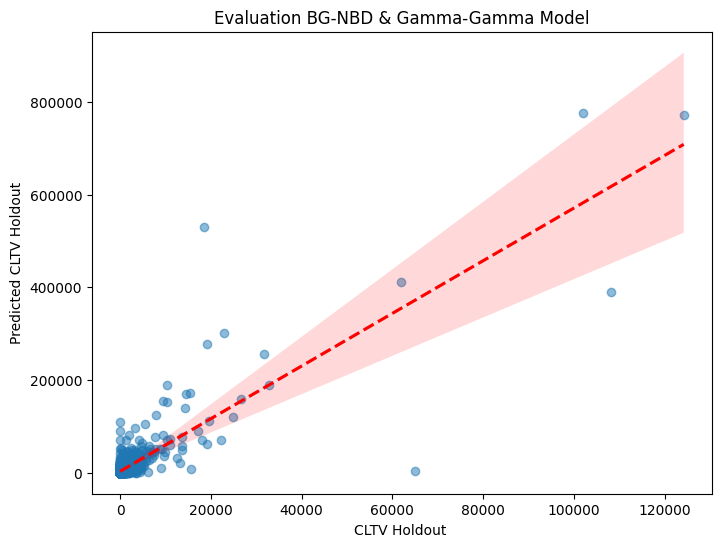

In [82]:
plt.figure(figsize=(8, 6))
sns.regplot(x='CLTV_holdout', y='predicted_CLTV', data=final_cltv_data,
            line_kws={'color': 'red', 'linestyle': '--'}, scatter_kws={'alpha': 0.5})
plt.xlabel("CLTV Holdout ")
plt.ylabel("Predicted CLTV Holdout")
plt.title("Evaluation BG-NBD & Gamma-Gamma Model")
plt.show()

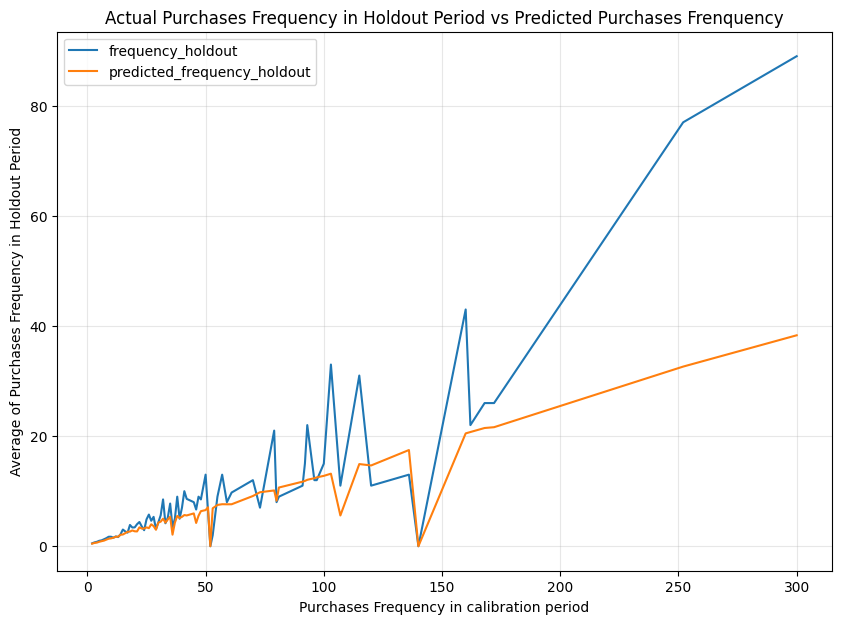

,frequency_cal,frequency_holdout,predicted_frequency_holdout
0,2,0.522702,0.466402
1,3,0.695271,0.596817
2,4,0.800948,0.655245
3,5,0.983444,0.805443
4,6,1.065502,0.917045


In [83]:
frequency_data = final_cltv_data.groupby('frequency_cal')[['frequency_holdout', 'predicted_frequency_holdout']].mean().reset_index()

plt.figure(figsize=(10, 7))
# Vẽ đường thực tế
plt.plot(frequency_data['frequency_cal'], frequency_data['frequency_holdout'], label='frequency_holdout')
# Vẽ đường dự đoán của mô hình
plt.plot(frequency_data['frequency_cal'], frequency_data['predicted_frequency_holdout'], label='predicted_frequency_holdout')

# Thiết lập các thông tin cho biểu đồ
plt.title('Actual Purchases Frequency in Holdout Period vs Predicted Purchases Frenquency')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of Purchases Frequency in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()
frequency_data.head()

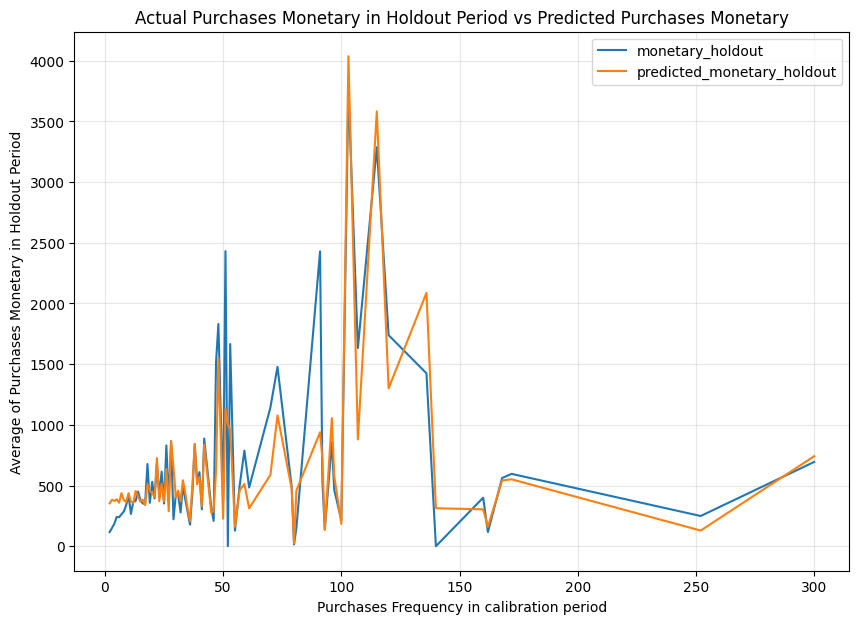

,frequency_cal,monetary_holdout,predicted_monetary_holdout
0,2,116.623574,353.176938
1,3,150.081946,382.871884
2,4,185.863655,372.572714
3,5,241.458862,386.175752
4,6,238.619068,357.941689


In [84]:
monetary_data = final_cltv_data.groupby('frequency_cal')[['monetary_holdout', 'predicted_monetary_holdout']].mean().reset_index()

plt.figure(figsize=(10, 7))
# Vẽ đường thực tế
plt.plot(monetary_data['frequency_cal'], monetary_data['monetary_holdout'], label='monetary_holdout')
# Vẽ đường dự đoán của mô hình
plt.plot(monetary_data['frequency_cal'], monetary_data['predicted_monetary_holdout'], label='predicted_monetary_holdout')
# Thiết lập các thông tin cho biểu đồ
plt.title('Actual Purchases Monetary in Holdout Period vs Predicted Purchases Monetary')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of Purchases Monetary in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()
monetary_data.head()

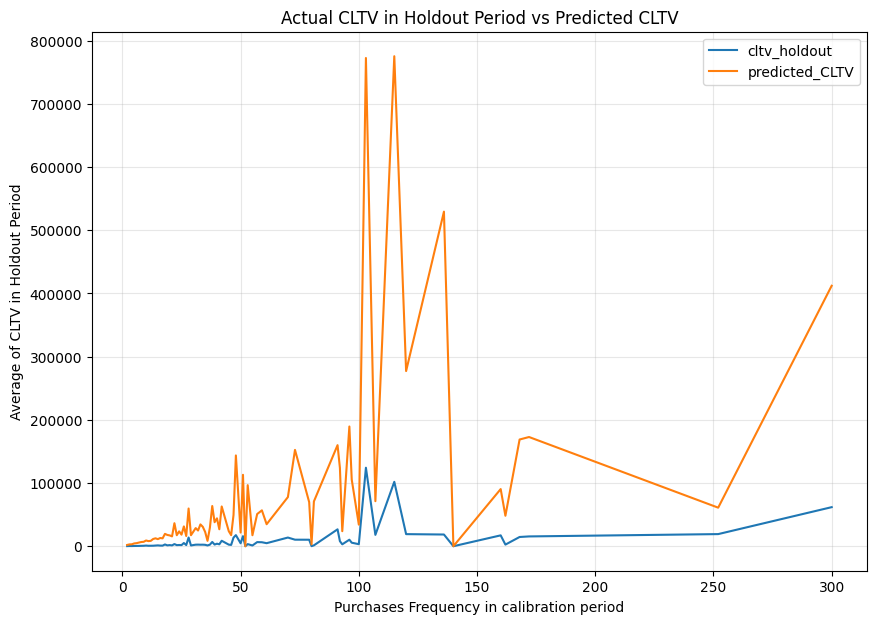

,frequency_cal,CLTV_holdout,predicted_CLTV
0,2,177.870210,2013.740817
1,3,336.828879,2895.807680
2,4,295.097372,3082.918594
3,5,396.369967,4421.049310
4,6,445.375677,4866.776078


In [85]:
plot_cltv_data = final_cltv_data.groupby('frequency_cal')[['CLTV_holdout', 'predicted_CLTV']].mean().reset_index()

plt.figure(figsize=(10, 7))
# Vẽ đường thực tế
plt.plot(plot_cltv_data['frequency_cal'], plot_cltv_data['CLTV_holdout'], label='cltv_holdout')
# Vẽ đường dự đoán của mô hình
plt.plot(plot_cltv_data['frequency_cal'], plot_cltv_data['predicted_CLTV'], label='predicted_CLTV')
# Thiết lập các thông tin cho biểu đồ
plt.title('Actual CLTV in Holdout Period vs Predicted CLTV')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of CLTV in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()
plot_cltv_data.head()

### Evaluation

In [86]:
#Evalute model
# BG-NBD model
def score_model(actuals, predicted, metric='mse'):
  # make sure metric name is lower case
  metric = metric.lower()
  
  # Mean Squared Error and Root Mean Squared Error
  if metric=='mse' or metric=='rmse':
    val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    if metric=='rmse':
        val = np.sqrt(val)
  
  # Mean Absolute Error
  elif metric=='mae':
    val = np.sum(np.abs(actuals-predicted))/actuals.shape[0]

  else:
      return None
  return val

In [87]:
print('MSE for BG-NBD model: {0}'.format(score_model(final_cltv_data['frequency_holdout'], final_cltv_data['predicted_frequency_holdout'], 'mse')))
print('RMSE for BG-NBD model: {0}'.format(score_model(final_cltv_data['frequency_holdout'], final_cltv_data['predicted_frequency_holdout'], 'rmse')))
print('MAE for BG-NBD model: {0}'.format(score_model(final_cltv_data['frequency_holdout'], final_cltv_data['predicted_frequency_holdout'], 'mae')))

MSE for BG-NBD model: 3.744310680040745
RMSE for BG-NBD model: 1.9350221394187574
MAE for BG-NBD model: 0.973716763062906


In [88]:
print('MSE for BG-NBD model: {0}'.format(score_model(final_cltv_data['monetary_holdout'], final_cltv_data['predicted_monetary_holdout'], 'mse')))
print('RMSE for BG-NBD model: {0}'.format(score_model(final_cltv_data['monetary_holdout'], final_cltv_data['predicted_monetary_holdout'], 'rmse')))
print('MAE for BG-NBD model: {0}'.format(score_model(final_cltv_data['monetary_holdout'], final_cltv_data['predicted_monetary_holdout'], 'mae')))

MSE for BG-NBD model: 326391.07301352307
RMSE for BG-NBD model: 571.3064615541497
MAE for BG-NBD model: 261.5160325150626


In [89]:
print('MSE for BG-NBD model: {0}'.format(score_model(final_cltv_data['CLTV_holdout'], final_cltv_data['predicted_CLTV'], 'mse')))
print('RMSE for BG-NBD model: {0}'.format(score_model(final_cltv_data['CLTV_holdout'], final_cltv_data['predicted_CLTV'], 'rmse')))
print('MAE for BG-NBD model: {0}'.format(score_model(final_cltv_data['CLTV_holdout'], final_cltv_data['predicted_CLTV'], 'mae')))

MSE for BG-NBD model: 577647629.3718897
RMSE for BG-NBD model: 24034.301100133736
MAE for BG-NBD model: 6552.404095382171


In [122]:
r2_score(train_df['frequency_holdout'], train_df['predicted_frequency_holdout'])

0.6120817714941587

In [123]:
r2_score(test_df['frequency_holdout'], test_df['predicted_frequency_holdout'])

0.5766245789758022

## Machine Learning

### Feature Engineering

In [90]:
feature_df = (calibration_df
.groupby('Customer ID')
 .agg({
     'StockCode': 'nunique',
     'Quantity': ["mean", "sum", "std"],
     "Price": ["mean", "sum", "std"],
     'Invoice Date': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days, #Rencecy
                     lambda InvoiceDate: (calibration_period_end - InvoiceDate.min()).days], #Tenure
     'Invoice': lambda Invoice: Invoice.nunique(), #frequency
     'Total Sales': lambda TotalSales: TotalSales.sum()
 })
)
feature_df.columns = feature_df.columns.droplevel(0)
feature_df.columns = ['num_product', 'mean_quantity', 'sum_quantity', 'std_quantity', 'mean_price','sum_price', 'std_price', 'recency', 'T', 'frequency','monetary']
feature_df.head()

,num_product,mean_quantity,sum_quantity,std_quantity,mean_price,sum_price,std_price,recency,T,frequency,monetary
Customer ID,,,,,,,,,,,
12346.0,26,2560.655172,74259,13781.087787,6.496552,188.40,1.649737,379,614,7,77442.96
12347.0,107,12.798780,2099,19.489554,2.562622,420.27,2.255966,274,313,6,3402.39
12348.0,25,52.020833,2497,48.268526,3.137500,150.60,9.626602,189,347,4,1709.40
12349.0,90,9.735294,993,8.292817,8.581765,875.34,31.299379,181,498,3,2671.14
12350.0,17,11.588235,197,4.345383,3.841176,65.30,9.334751,0,219,1,334.40


In [91]:
# Merge Feature and Label 
data_df = pd.merge(final_cltv_data.reset_index()[['Customer ID', 'frequency_cal', 'frequency_holdout', 'predicted_frequency_holdout']], feature_df, how='left', on='Customer ID')
data_df.head()

,Customer ID,frequency_cal,frequency_holdout,predicted_frequency_holdout,num_product,mean_quantity,sum_quantity,std_quantity,mean_price,sum_price,std_price,recency,T,frequency,monetary
0,12346.0,7,0,0.428666,26,2560.655172,74259,13781.087787,6.496552,188.40,1.649737,379,614,7,77442.96
1,12347.0,6,2,1.579065,107,12.798780,2099,19.489554,2.562622,420.27,2.255966,274,313,6,3402.39
2,12348.0,4,1,0.625955,25,52.020833,2497,48.268526,3.137500,150.60,9.626602,189,347,4,1709.40
3,12349.0,3,1,0.165178,90,9.735294,993,8.292817,8.581765,875.34,31.299379,181,498,3,2671.14
4,12352.0,7,3,0.210852,38,7.892857,442,5.375630,19.601429,1097.68,65.595357,130,302,7,1905.61


In [94]:
from sklearn.model_selection import train_test_split
user_train, user_test = train_test_split(data_df["Customer ID"].drop_duplicates(), test_size=0.3, random_state=42)
user_train.shape, user_test.shape

((2533,), (1086,))

In [95]:
train_df = data_df.merge(user_train)
train_df.head()

,Customer ID,frequency_cal,frequency_holdout,predicted_frequency_holdout,num_product,mean_quantity,sum_quantity,std_quantity,mean_price,sum_price,std_price,recency,T,frequency,monetary
0,12347.0,6,2,1.579065,107,12.798780,2099,19.489554,2.562622,420.27,2.255966,274,313,6,3402.39
1,12348.0,4,1,0.625955,25,52.020833,2497,48.268526,3.137500,150.60,9.626602,189,347,4,1709.40
2,12349.0,3,1,0.165178,90,9.735294,993,8.292817,8.581765,875.34,31.299379,181,498,3,2671.14
3,12352.0,7,3,0.210852,38,7.892857,442,5.375630,19.601429,1097.68,65.595357,130,302,7,1905.61
4,12353.0,2,0,0.643490,23,8.833333,212,3.484957,2.628333,63.08,2.536731,204,318,2,406.76


In [96]:
test_df = data_df.merge(user_test)
test_df.head()

,Customer ID,frequency_cal,frequency_holdout,predicted_frequency_holdout,num_product,mean_quantity,sum_quantity,std_quantity,mean_price,sum_price,std_price,recency,T,frequency,monetary
0,12346.0,7,0,0.428666,26,2560.655172,74259,13781.087787,6.496552,188.40,1.649737,379,614,7,77442.96
1,12356.0,5,1,0.621107,104,24.364286,3411,22.544986,3.032857,424.60,4.124638,179,334,5,6313.38
2,12361.0,4,0,0.527437,18,8.103448,235,4.177703,3.870690,112.25,4.558499,394,591,4,511.25
3,12363.0,2,0,1.282634,23,17.739130,408,9.250147,2.311739,53.17,2.458558,132,151,2,552.00
4,12370.0,6,1,0.654206,150,12.855491,2224,31.838015,3.498150,605.18,5.938144,394,578,6,3577.28


### Modelling

In [97]:
feature_cols = train_df.drop(columns= ['Customer ID', 'frequency_holdout', 'predicted_frequency_holdout', 'frequency_cal']).columns.values
feature_cols

array(['num_product', 'mean_quantity', 'sum_quantity', 'std_quantity',
       'mean_price', 'sum_price', 'std_price', 'recency', 'T',
       'frequency', 'monetary'], dtype=object)

In [98]:
#linear regression 
import numpy as np
from sklearn.linear_model import LinearRegression
X_train = train_df[feature_cols]
y_train = train_df.frequency_holdout
reg = LinearRegression().fit(X_train, y_train)

In [99]:
train_df["linear_pred"] = reg.predict(train_df[feature_cols])
reg.score(train_df[feature_cols], train_df.frequency_holdout)

0.6581218505210222

In [100]:
test_df["linear_pred"] = reg.predict(test_df[feature_cols])
reg.score(test_df[feature_cols], test_df.frequency_holdout)

0.6239783062870277

In [101]:
#decision tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
X_train = train_df[feature_cols]
y_train = train_df.frequency_holdout
regressor = DecisionTreeRegressor(random_state=0, max_depth=10, min_samples_leaf=5)
final_regressor = regressor.fit(X_train, y_train)

In [102]:
train_df["tree_pred"] = final_regressor.predict(train_df[feature_cols])
reg.score(train_df[feature_cols], train_df.frequency_holdout)

0.6581218505210222

In [103]:
test_df["tree_pred"] = final_regressor.predict(test_df[feature_cols])
final_regressor.score(test_df[feature_cols], test_df.frequency_holdout)

0.5234798738799209

In [104]:
#Multi-layer Perceptron
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X_train = train_df[feature_cols]
y_train = train_df.frequency_holdout

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

regr = MLPRegressor(random_state=1)
regr.fit(X_train_scaled, y_train)
regr.score(X_train_scaled, y_train)

C:\Users\Linh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.78128942044918

In [105]:
train_df["perceptron_pred"] = regr.predict(X_train_scaled)
regr.score(X_train_scaled, train_df.frequency_holdout)

0.78128942044918

In [106]:
X_test_scaled = scaler.transform(test_df[feature_cols])
test_df["perceptron_pred"] = regr.predict(X_test_scaled)
regr.score(X_test_scaled, test_df.frequency_holdout)

0.5157443864913178

In [107]:
frequency_data = test_df.groupby('frequency_cal')[['frequency_holdout', 'predicted_frequency_holdout', 'linear_pred', 'tree_pred', 'perceptron_pred']].mean().reset_index()
frequency_data.head()

,frequency_cal,frequency_holdout,predicted_frequency_holdout,linear_pred,tree_pred,perceptron_pred
0,2,0.483019,0.454483,0.426220,0.582759,0.590785
1,3,0.645833,0.580333,0.612421,0.664830,0.726886
2,4,0.963636,0.596460,0.696299,0.674995,0.757255
3,5,1.000000,0.783377,0.905934,0.908082,0.867574
4,6,1.144737,0.866403,0.997184,0.977802,1.019089


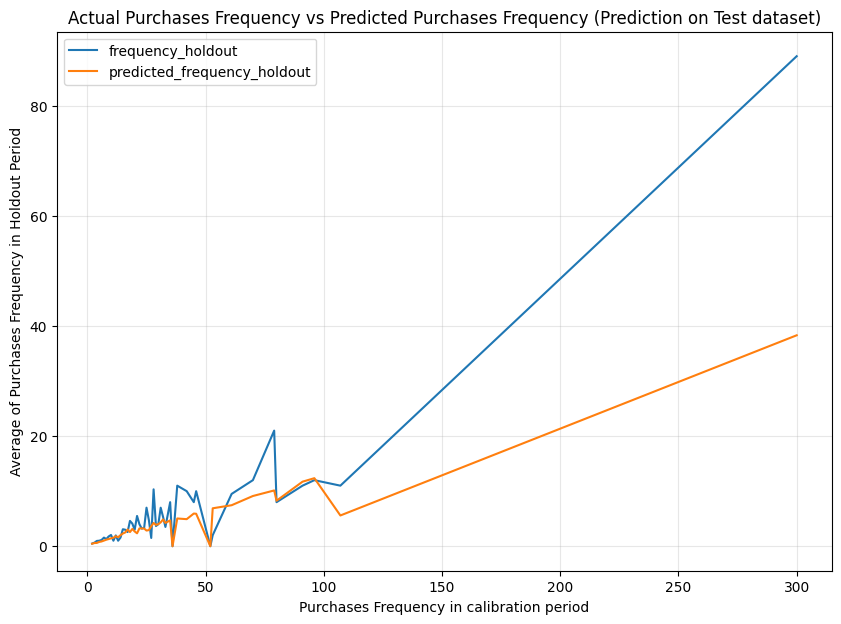

In [108]:
plt.figure(figsize=(10, 7))

# Vẽ đường thực tế
plt.plot(frequency_data['frequency_cal'], frequency_data['frequency_holdout'], label='frequency_holdout')
plt.plot(frequency_data['frequency_cal'], frequency_data['predicted_frequency_holdout'], label='predicted_frequency_holdout')
# Thiết lập các thông tin cho biểu đồ
plt.title('Actual Purchases Frequency vs Predicted Purchases Frequency (Prediction on Test dataset)')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of Purchases Frequency in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()

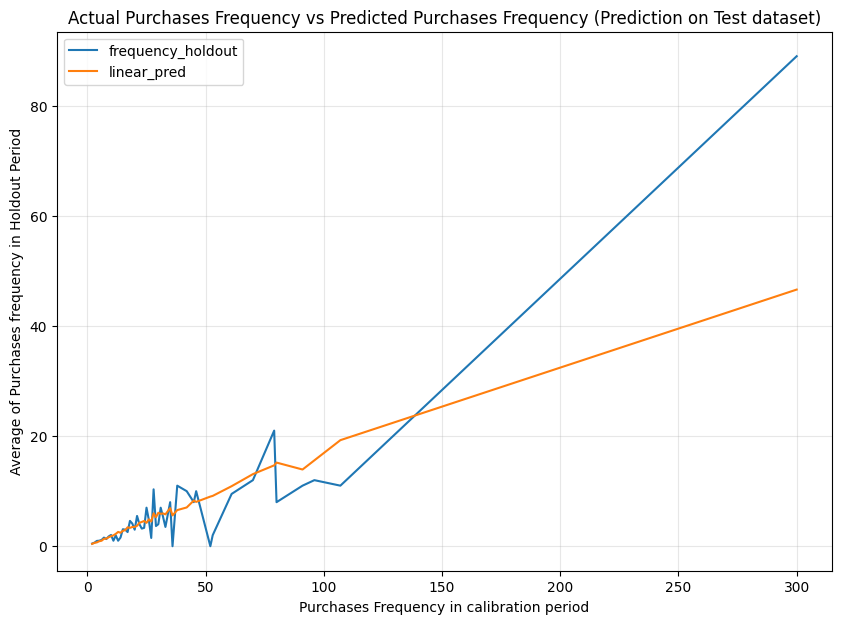

In [109]:
plt.figure(figsize=(10, 7))

# Vẽ đường thực tế
plt.plot(frequency_data['frequency_cal'], frequency_data['frequency_holdout'], label='frequency_holdout')
plt.plot(frequency_data['frequency_cal'], frequency_data['linear_pred'], label='linear_pred')
# Thiết lập các thông tin cho biểu đồ
plt.title('Actual Purchases Frequency vs Predicted Purchases Frequency (Prediction on Test dataset)')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of Purchases frequency in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()

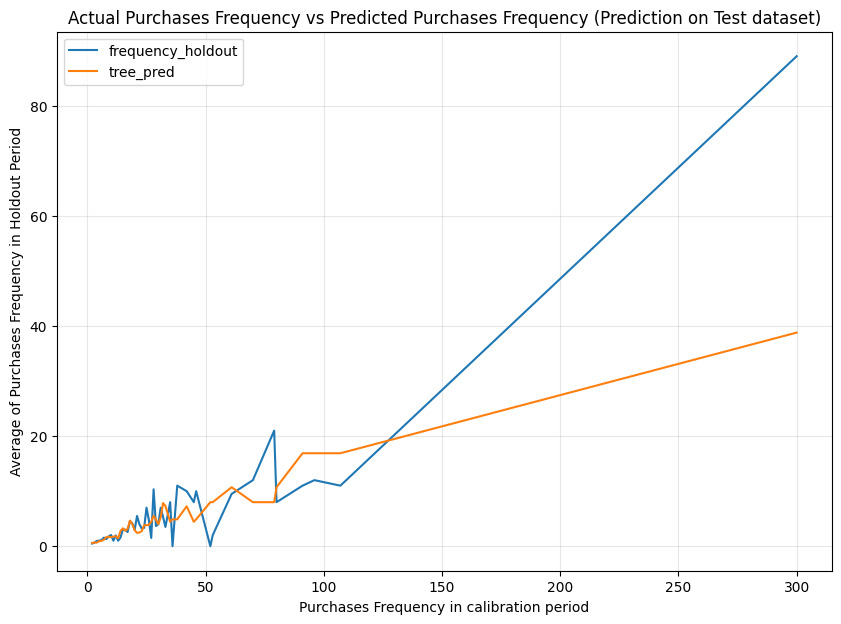

In [110]:
plt.figure(figsize=(10, 7))

# Vẽ đường thực tế
plt.plot(frequency_data['frequency_cal'], frequency_data['frequency_holdout'], label='frequency_holdout')
plt.plot(frequency_data['frequency_cal'], frequency_data['tree_pred'], label='tree_pred')
# Thiết lập các thông tin cho biểu đồ
plt.title('Actual Purchases Frequency vs Predicted Purchases Frequency (Prediction on Test dataset)')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of Purchases Frequency in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()

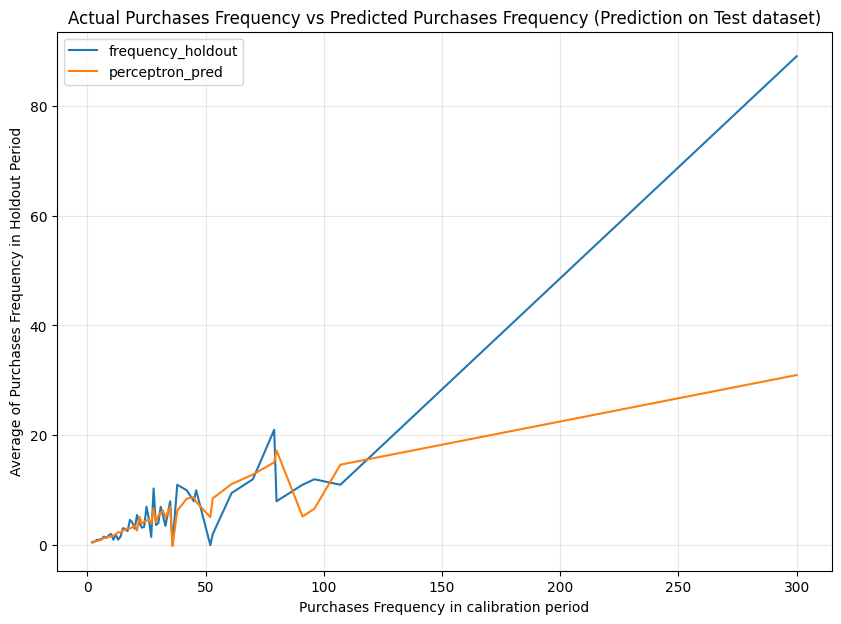

In [111]:
plt.figure(figsize=(10, 7))

# Vẽ đường thực tế
plt.plot(frequency_data['frequency_cal'], frequency_data['frequency_holdout'], label='frequency_holdout')
plt.plot(frequency_data['frequency_cal'], frequency_data['perceptron_pred'], label='perceptron_pred')
# Thiết lập các thông tin cho biểu đồ
plt.title('Actual Purchases Frequency vs Predicted Purchases Frequency (Prediction on Test dataset)')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of Purchases Frequency in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()

In [112]:
print('MSE for BG-NBD model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['predicted_frequency_holdout'], 'mse')))
print('MSE for Linear model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['linear_pred'], 'mse')))
print('MSE for Tree   model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['tree_pred'], 'mse')))
print('MSE for Neural model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['perceptron_pred'], 'mse')))

MSE for BG-NBD model: 4.959693672827352
MSE for Linear model: 4.404961465742394
MSE for Tree   model: 5.582265141361549
MSE for Neural model: 5.6728836467171


In [131]:
print('RMSE for BG-NBD model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['predicted_frequency_holdout'], 'rmse')))
print('RMSE for Linear model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['linear_pred'], 'rmse')))
print('RMSE for Tree   model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['tree_pred'], 'rmse')))
print('RMSE for Neural model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['perceptron_pred'], 'rmse')))

RMSE for BG-NBD model: 2.2270369715896843
RMSE for Linear model: 2.0988000061326457
RMSE for Tree   model: 2.3626817689569513
RMSE for Neural model: 2.3817816118857538


In [132]:
print('MAE for BG-NBD model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['predicted_frequency_holdout'], 'mae')))
print('MAE for Linear model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['linear_pred'], 'mae')))
print('MAE for Tree   model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['tree_pred'], 'mae')))
print('MAE for Neural model: {0}'.format(score_model(test_df['frequency_holdout'], test_df['perceptron_pred'], 'mae')))

MAE for BG-NBD model: 1.0178536175582775
MAE for Linear model: 1.0734141013584906
MAE for Tree   model: 1.1884928190171102
MAE for Neural model: 1.0703502035474357


In [115]:
print('MSE for BG-NBD model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['predicted_frequency_holdout'], 'mse')))
print('MSE for Linear model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['linear_pred'], 'mse')))
print('MSE for Tree   model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['tree_pred'], 'mse')))
print('MSE for Neural model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['perceptron_pred'], 'mse')))

MSE for BG-NBD model: 3.2232266175984807
MSE for Linear model: 2.8406779326157907
MSE for Tree   model: 2.428887375322299
MSE for Neural model: 1.8172741308751812


In [129]:
print('RMSE for BG-NBD model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['predicted_frequency_holdout'], 'rmse')))
print('RMSE for Linear model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['linear_pred'], 'rmse')))
print('RMSE for Tree   model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['tree_pred'], 'rmse')))
print('RMSE for Neural model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['perceptron_pred'], 'rmse')))

RMSE for BG-NBD model: 1.7953346812219946
RMSE for Linear model: 1.6854310821317466
RMSE for Tree   model: 1.5584888114203128
RMSE for Neural model: 1.348063103447009


In [130]:
print('MAE for BG-NBD model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['predicted_frequency_holdout'], 'mae')))
print('MAE for Linear model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['linear_pred'], 'mae')))
print('MAE for Tree   model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['tree_pred'], 'mae')))
print('MAE for Neural model: {0}'.format(score_model(train_df['frequency_holdout'], train_df['perceptron_pred'], 'mae')))

MAE for BG-NBD model: 0.9547935005354784
MAE for Linear model: 1.0111391464133472
MAE for Tree   model: 0.8372808375267973
MAE for Neural model: 0.9201849112344713


In [124]:
frequency_data = train_df.groupby('frequency_cal')[['frequency_holdout', 'predicted_frequency_holdout', 'linear_pred', 'tree_pred', 'perceptron_pred']].mean().reset_index()
frequency_data.head()

,frequency_cal,frequency_holdout,predicted_frequency_holdout,linear_pred,tree_pred,perceptron_pred
0,2,0.539185,0.471353,0.456615,0.590660,0.600786
1,3,0.720317,0.605168,0.594869,0.716521,0.705798
2,4,0.743590,0.675971,0.680607,0.642940,0.772374
3,5,0.976744,0.814372,0.854635,0.993848,0.895028
4,6,1.026144,0.942200,1.065374,1.026121,1.067173


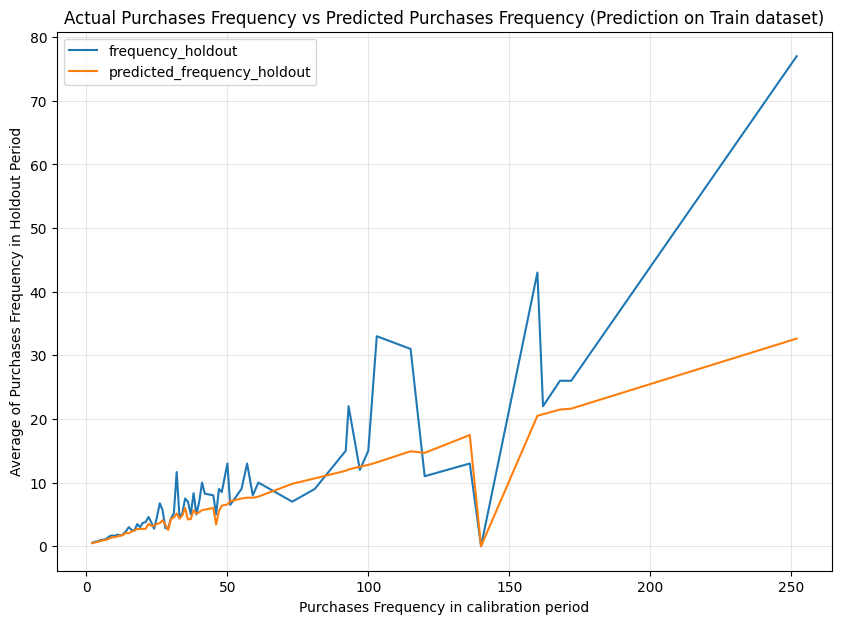

In [125]:
plt.figure(figsize=(10, 7))

# Vẽ đường thực tế
plt.plot(frequency_data['frequency_cal'], frequency_data['frequency_holdout'], label='frequency_holdout')
plt.plot(frequency_data['frequency_cal'], frequency_data['predicted_frequency_holdout'], label='predicted_frequency_holdout')
# Thiết lập các thông tin cho biểu đồ
plt.title('Actual Purchases Frequency vs Predicted Purchases Frequency (Prediction on Train dataset)')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of Purchases Frequency in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()

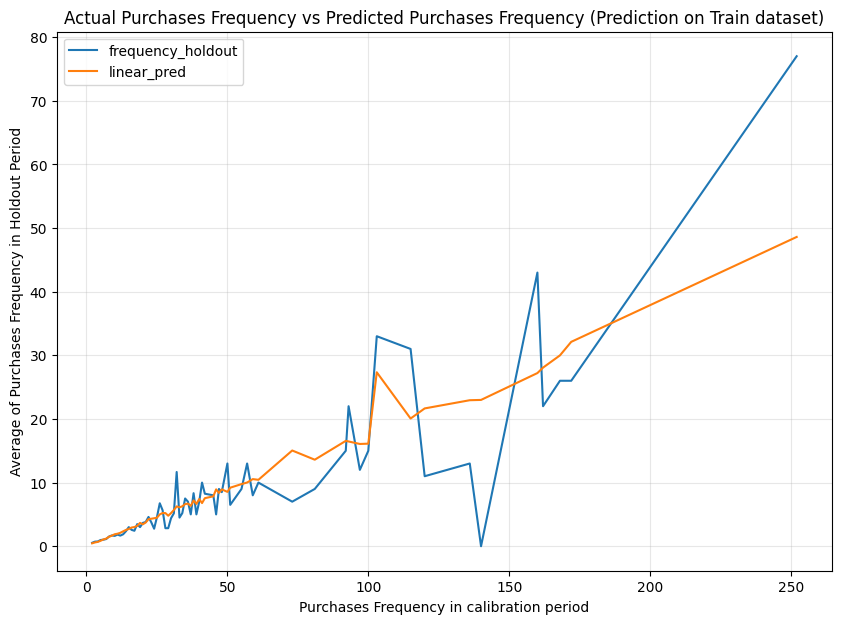

In [126]:
plt.figure(figsize=(10, 7))

# Vẽ đường thực tế
plt.plot(frequency_data['frequency_cal'], frequency_data['frequency_holdout'], label='frequency_holdout')
plt.plot(frequency_data['frequency_cal'], frequency_data['linear_pred'], label='linear_pred')
# Thiết lập các thông tin cho biểu đồ
plt.title('Actual Purchases Frequency vs Predicted Purchases Frequency (Prediction on Train dataset)')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of Purchases Frequency in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()

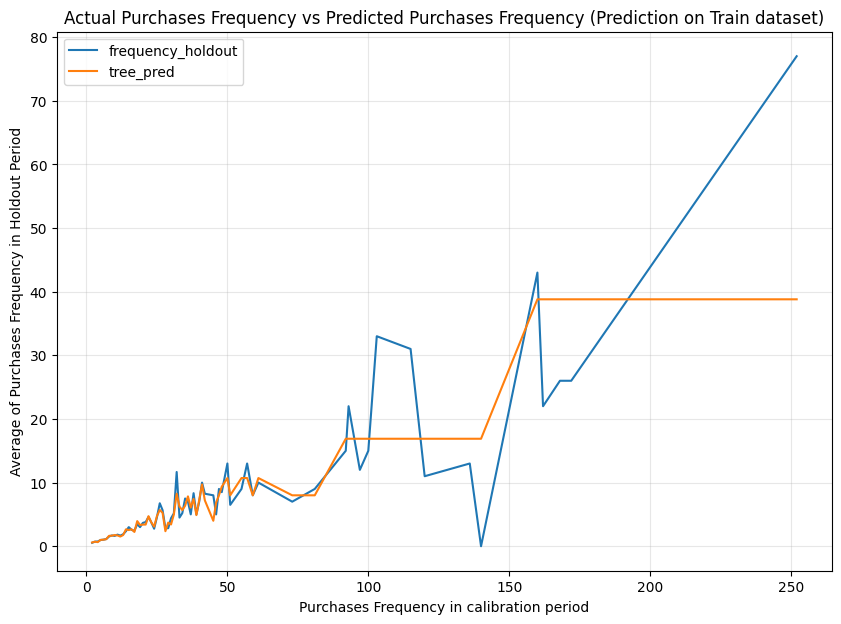

In [127]:
plt.figure(figsize=(10, 7))

# Vẽ đường thực tế
plt.plot(frequency_data['frequency_cal'], frequency_data['frequency_holdout'], label='frequency_holdout')
plt.plot(frequency_data['frequency_cal'], frequency_data['tree_pred'], label='tree_pred')
# Thiết lập các thông tin cho biểu đồ
plt.title('Actual Purchases Frequency vs Predicted Purchases Frequency (Prediction on Train dataset)')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of Purchases Frequency in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()

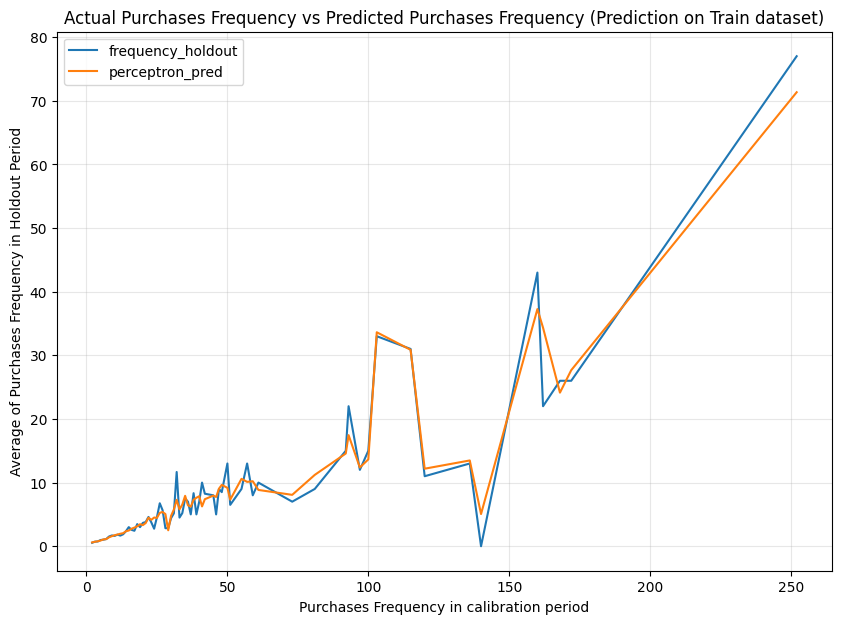

In [128]:
plt.figure(figsize=(10, 7))

# Vẽ đường thực tế
plt.plot(frequency_data['frequency_cal'], frequency_data['frequency_holdout'], label='frequency_holdout')
plt.plot(frequency_data['frequency_cal'], frequency_data['perceptron_pred'], label='perceptron_pred')
# Thiết lập các thông tin cho biểu đồ
plt.title('Actual Purchases Frequency vs Predicted Purchases Frequency (Prediction on Train dataset)')
plt.xlabel('Purchases Frequency in calibration period')
plt.ylabel('Average of Purchases Frequency in Holdout Period')
plt.legend()
plt.grid(alpha=0.3) # Thêm lưới mờ cho dễ nhìn

# Hiển thị biểu đồ
plt.show()